### Load Python Package

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
from datetime import date
import seaborn as sns
from shapely.geometry import Point, MultiPolygon
import geojson
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy as sp
from statsmodels.graphics import utils
import statsmodels.stats.api as sms
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
import statsmodels.stats.stattools as stools
%matplotlib inline

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

In [3]:
warnings.filterwarnings('ignore')

In [4]:
def Impact_In_Category(x, y, data):
    sns.stripplot(x = x, y = y, data = data, jitter = True, alpha = .3)
    sns.pointplot(x = x, y = y, data = data, dodge = True, color = 'r')
    plt.show()
    model = sm.OLS.from_formula("{} ~ C({}) + 0".format(y, x), data = data)
    return sm.stats.anova_lm(model.fit())

### Load Training dataet

In [5]:
train = pd.read_csv('./data/transformed_train.csv')
print ("Training data has {} rows and {} columns".format(train.shape[0],train.shape[1]))
print ("data : {}".format(train.shape[0]))
print ("Feature : {}".format(train.shape[1]))

Training data has 701778 rows and 32 columns
data : 701778
Feature : 32


In [6]:
train.shape

(701778, 32)

## feature Selection

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701778 entries, 0 to 701777
Data columns (total 32 columns):
id                              701778 non-null object
vendor_id                       701778 non-null int64
pickup_datetime                 701778 non-null object
dropoff_datetime                701778 non-null object
passenger_count                 701778 non-null int64
pickup_longitude                701778 non-null float64
pickup_latitude                 701778 non-null float64
dropoff_longitude               701778 non-null float64
dropoff_latitude                701778 non-null float64
store_and_fwd_flag              701778 non-null object
trip_duration                   701778 non-null int64
pickup_date                     701778 non-null object
pickup_time                     701778 non-null object
month                           701778 non-null int64
day                             701778 non-null int64
hr                              701778 non-null int64
minute     

In [8]:
train['log_trip_duration'] = train.trip_duration.apply(np.log)

##  변수 선정
### F-검정을 사용한 변수 중요도 비교
* speed_kmph & speed_kmph_dummy는 test set에서는 trip duration이 없으므로 계산이 불가능하므로 제외함.

In [9]:
formulaX = 'trip_duration ~ distance + dummy_manhattan_dist + bearing + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude + hour_day_of_week_float'
modelx = sm.OLS.from_formula(formulaX, train)
result = modelx.fit()
sm.stats.anova_lm(result, typ = 2)

,sum_sq,df,F,PR(>F)
distance,7.733405e+09,1.0,169.496661,9.629375e-39
dummy_manhattan_dist,2.313566e+09,1.0,50.707509,1.073107e-12
bearing,3.731938e+05,1.0,0.008179,9.279373e-01
pickup_longitude,4.654584e+08,1.0,10.201670,1.403197e-03
pickup_latitude,5.038902e+04,1.0,0.001104,9.734892e-01
dropoff_longitude,6.143851e+07,1.0,1.346577,2.458779e-01
dropoff_latitude,8.914290e+07,1.0,1.953787,1.621798e-01
hour_day_of_week_float,1.250495e+06,1.0,0.027408,8.685091e-01
Residual,3.201871e+13,701769.0,NaN,NaN


In [10]:
formulaX = 'I(np.log(trip_duration)) ~ distance + dummy_manhattan_dist + bearing + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude + hour_day_of_week_float'
modelx = sm.OLS.from_formula(formulaX, train)
result = modelx.fit()
sm.stats.anova_lm(result, typ = 2)

,sum_sq,df,F,PR(>F)
distance,15803.775432,1.0,39065.412336,0.000000e+00
dummy_manhattan_dist,7251.063538,1.0,17923.931418,0.000000e+00
bearing,131.857271,1.0,325.938487,7.654883e-73
pickup_longitude,1894.956496,1.0,4684.150139,0.000000e+00
pickup_latitude,337.850465,1.0,835.133845,1.590783e-183
dropoff_longitude,437.242442,1.0,1080.821248,7.382309e-237
dropoff_latitude,305.247068,1.0,754.541382,5.060570e-166
hour_day_of_week_float,264.904171,1.0,654.817623,2.332811e-144
Residual,283898.185577,701769.0,NaN,NaN


In [11]:
formulaX = 'I(np.log(trip_duration)) ~ I(np.log(distance+1)) + dummy_manhattan_dist + bearing + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude + hour_day_of_week_float'
modelx = sm.OLS.from_formula(formulaX, train)
result = modelx.fit()
sm.stats.anova_lm(result, typ = 2)

,sum_sq,df,F,PR(>F)
I(np.log(distance + 1)),119075.890186,1.0,462634.037262,0.000000e+00
dummy_manhattan_dist,5815.153994,1.0,22593.055281,0.000000e+00
bearing,835.831331,1.0,3247.374615,0.000000e+00
pickup_longitude,0.251700,1.0,0.977906,3.227167e-01
pickup_latitude,16.464687,1.0,63.968654,1.266048e-15
dropoff_longitude,2147.305107,1.0,8342.716813,0.000000e+00
dropoff_latitude,769.535298,1.0,2989.801051,0.000000e+00
hour_day_of_week_float,591.485919,1.0,2298.043023,0.000000e+00
Residual,180626.070823,701769.0,NaN,NaN


In [12]:
formulaX = 'trip_duration ~ I(np.log(distance+1)) + dummy_manhattan_dist + bearing + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude + hour_day_of_week_float'
modelx = sm.OLS.from_formula(formulaX, train)
result = modelx.fit()
sm.stats.anova_lm(result, typ = 2)

,sum_sq,df,F,PR(>F)
I(np.log(distance + 1)),3.884753e+10,1.0,852.267749,3.027641e-187
dummy_manhattan_dist,1.659220e+09,1.0,36.401265,1.606789e-09
bearing,5.255581e+08,1.0,11.530107,6.848187e-04
pickup_longitude,2.196624e+09,1.0,48.191255,3.869418e-12
pickup_latitude,4.310347e+07,1.0,0.945638,3.308325e-01
dropoff_longitude,8.989749e+08,1.0,19.722419,8.955832e-06
dropoff_latitude,2.996535e+08,1.0,6.574034,1.034792e-02
hour_day_of_week_float,3.188885e+07,1.0,0.699603,4.029175e-01
Residual,3.198759e+13,701769.0,NaN,NaN


In [13]:
formulaX = 'I(np.log(trip_duration)) ~ I(np.log(dummy_manhattan_dist+1)) + distance + bearing + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude + hour_day_of_week_float'
modelx = sm.OLS.from_formula(formulaX, train)
result = modelx.fit()
sm.stats.anova_lm(result, typ = 2)

,sum_sq,df,F,PR(>F)
I(np.log(dummy_manhattan_dist + 1)),105008.064690,1.0,395889.844461,0.000000e+00
distance,3772.641471,1.0,14223.197519,0.000000e+00
bearing,1072.540700,1.0,4043.574862,0.000000e+00
pickup_longitude,6.152283,1.0,23.194659,1.464338e-06
pickup_latitude,105.723139,1.0,398.585738,1.184395e-88
dropoff_longitude,2012.884175,1.0,7588.754306,0.000000e+00
dropoff_latitude,1168.057555,1.0,4403.681995,0.000000e+00
hour_day_of_week_float,565.529005,1.0,2132.095193,0.000000e+00
Residual,186141.184425,701769.0,NaN,NaN


In [14]:
formulaX = 'trip_duration ~ I(np.log(dummy_manhattan_dist+1)) + distance + bearing + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude + hour_day_of_week_float'
modelx = sm.OLS.from_formula(formulaX, train)
result = modelx.fit()
sm.stats.anova_lm(result, typ = 2)

,sum_sq,df,F,PR(>F)
I(np.log(dummy_manhattan_dist + 1)),3.020488e+10,1.0,662.591727,4.772924e-146
distance,3.213474e+09,1.0,70.492620,4.628331e-17
bearing,5.348988e+08,1.0,11.733849,6.137704e-04
pickup_longitude,2.094575e+09,1.0,45.947815,1.215406e-11
pickup_latitude,1.854913e+07,1.0,0.406904,5.235451e-01
dropoff_longitude,7.447847e+08,1.0,16.338027,5.299551e-05
dropoff_latitude,3.495373e+08,1.0,7.667651,5.622107e-03
hour_day_of_week_float,2.639547e+07,1.0,0.579026,4.466945e-01
Residual,3.199082e+13,701769.0,NaN,NaN


In [15]:
formulaX = 'I(np.log(trip_duration)) ~ I(np.log(dummy_manhattan_dist+1)) + I(np.log(distance+1))+ bearing + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude + hour_day_of_week_float'
modelx = sm.OLS.from_formula(formulaX, train)
result = modelx.fit()
sm.stats.anova_lm(result, typ = 2)

,sum_sq,df,F,PR(>F)
I(np.log(dummy_manhattan_dist + 1)),29.834530,1.0,112.315821,3.060911e-26
I(np.log(distance + 1)),3502.435609,1.0,13185.357025,0.000000e+00
bearing,397.842061,1.0,1497.726211,0.000000e+00
pickup_longitude,501.289264,1.0,1887.166148,0.000000e+00
pickup_latitude,344.062735,1.0,1295.267210,2.194688e-283
dropoff_longitude,1166.433404,1.0,4391.184479,0.000000e+00
dropoff_latitude,745.147818,1.0,2805.202185,0.000000e+00
hour_day_of_week_float,537.801039,1.0,2024.619295,0.000000e+00
Residual,186411.390287,701769.0,NaN,NaN


In [16]:
formulaX = 'trip_duration ~ I(np.log(dummy_manhattan_dist+1)) + I(np.log(distance+1))+ bearing + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude + hour_day_of_week_float'
modelx = sm.OLS.from_formula(formulaX, train)
result = modelx.fit()
sm.stats.anova_lm(result, typ = 2)

,sum_sq,df,F,PR(>F)
I(np.log(dummy_manhattan_dist + 1)),1.113613e+09,1.0,24.430897,7.704116e-07
I(np.log(distance + 1)),5.890678e+09,1.0,129.232134,6.069862e-30
bearing,6.159220e+08,1.0,13.512352,2.370160e-04
pickup_longitude,3.399827e+09,1.0,74.586809,5.814785e-18
pickup_latitude,2.565484e+08,1.0,5.628265,1.767338e-02
dropoff_longitude,1.306295e+09,1.0,28.658036,8.638191e-08
dropoff_latitude,2.169212e+08,1.0,4.758907,2.914739e-02
hour_day_of_week_float,4.030970e+07,1.0,0.884331,3.470185e-01
Residual,3.198814e+13,701769.0,NaN,NaN


In [17]:
formulaX = 'I(np.log(trip_duration)) ~ I(np.log(dummy_manhattan_dist+1)) + I(np.log(distance+1))+ scale(bearing) + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude + hour_day_of_week_float'
modelx = sm.OLS.from_formula(formulaX, train)
result = modelx.fit()
sm.stats.anova_lm(result, typ = 2)

,sum_sq,df,F,PR(>F)
I(np.log(dummy_manhattan_dist + 1)),29.834530,1.0,112.315821,3.060911e-26
I(np.log(distance + 1)),3502.435609,1.0,13185.357025,0.000000e+00
scale(bearing),397.842061,1.0,1497.726211,0.000000e+00
pickup_longitude,501.289264,1.0,1887.166148,0.000000e+00
pickup_latitude,344.062735,1.0,1295.267210,2.194688e-283
dropoff_longitude,1166.433404,1.0,4391.184479,0.000000e+00
dropoff_latitude,745.147818,1.0,2805.202185,0.000000e+00
hour_day_of_week_float,537.801039,1.0,2024.619295,0.000000e+00
Residual,186411.390287,701769.0,NaN,NaN


In [18]:
formulaX = 'trip_duration ~ I(np.log(dummy_manhattan_dist+1)) + I(np.log(distance+1))+ scale(bearing) + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude + hour_day_of_week_float'
modelx = sm.OLS.from_formula(formulaX, train)
result = modelx.fit()
sm.stats.anova_lm(result, typ = 2)

,sum_sq,df,F,PR(>F)
I(np.log(dummy_manhattan_dist + 1)),1.113613e+09,1.0,24.430897,7.704116e-07
I(np.log(distance + 1)),5.890678e+09,1.0,129.232134,6.069862e-30
scale(bearing),6.159220e+08,1.0,13.512352,2.370160e-04
pickup_longitude,3.399827e+09,1.0,74.586809,5.814785e-18
pickup_latitude,2.565484e+08,1.0,5.628265,1.767338e-02
dropoff_longitude,1.306295e+09,1.0,28.658036,8.638191e-08
dropoff_latitude,2.169212e+08,1.0,4.758907,2.914739e-02
hour_day_of_week_float,4.030970e+07,1.0,0.884331,3.470185e-01
Residual,3.198814e+13,701769.0,NaN,NaN


In [19]:
formulaX = 'I(np.log(trip_duration)) ~ I(np.log(distance+1)) +I(np.log(dummy_manhattan_dist+1))+scale(bearing)+scale(pickup_longitude)+scale(pickup_latitude)+scale(dropoff_longitude)+scale(dropoff_latitude) + hour_day_of_week_float'
modelx = sm.OLS.from_formula(formulaX, train)
result = modelx.fit()
sm.stats.anova_lm(result, typ = 2)


,sum_sq,df,F,PR(>F)
I(np.log(distance + 1)),3502.435609,1.0,13185.357025,0.000000e+00
I(np.log(dummy_manhattan_dist + 1)),29.834530,1.0,112.315821,3.060911e-26
scale(bearing),397.842061,1.0,1497.726211,0.000000e+00
scale(pickup_longitude),501.289264,1.0,1887.166148,0.000000e+00
scale(pickup_latitude),344.062735,1.0,1295.267210,2.194688e-283
scale(dropoff_longitude),1166.433404,1.0,4391.184479,0.000000e+00
scale(dropoff_latitude),745.147818,1.0,2805.202185,0.000000e+00
hour_day_of_week_float,537.801039,1.0,2024.619295,0.000000e+00
Residual,186411.390287,701769.0,NaN,NaN


In [20]:
formulaX = 'trip_duration ~ I(np.log(distance+1)) +I(np.log(dummy_manhattan_dist+1))+scale(bearing)+scale(pickup_longitude)+scale(pickup_latitude)+scale(dropoff_longitude)+scale(dropoff_latitude) + hour_day_of_week_float'
modelx = sm.OLS.from_formula(formulaX, train)
result = modelx.fit()
sm.stats.anova_lm(result, typ = 2)


,sum_sq,df,F,PR(>F)
I(np.log(distance + 1)),5.890678e+09,1.0,129.232134,6.069862e-30
I(np.log(dummy_manhattan_dist + 1)),1.113613e+09,1.0,24.430897,7.704116e-07
scale(bearing),6.159220e+08,1.0,13.512352,2.370160e-04
scale(pickup_longitude),3.399827e+09,1.0,74.586809,5.814785e-18
scale(pickup_latitude),2.565484e+08,1.0,5.628265,1.767338e-02
scale(dropoff_longitude),1.306295e+09,1.0,28.658036,8.638191e-08
scale(dropoff_latitude),2.169212e+08,1.0,4.758907,2.914739e-02
hour_day_of_week_float,4.030970e+07,1.0,0.884331,3.470185e-01
Residual,3.198814e+13,701769.0,NaN,NaN


In [21]:
formulaX = 'I(np.log(trip_duration)) ~ I(np.log(distance+1)) +I(np.log(dummy_manhattan_dist+1))+scale(bearing)+scale(pickup_longitude)+scale(pickup_latitude)+scale(dropoff_longitude)+scale(dropoff_latitude) + scale(hour_day_of_week_float)'
modelx = sm.OLS.from_formula(formulaX, train)
result = modelx.fit()
sm.stats.anova_lm(result, typ = 2)


,sum_sq,df,F,PR(>F)
I(np.log(distance + 1)),3502.435609,1.0,13185.357025,0.000000e+00
I(np.log(dummy_manhattan_dist + 1)),29.834530,1.0,112.315821,3.060911e-26
scale(bearing),397.842061,1.0,1497.726211,0.000000e+00
scale(pickup_longitude),501.289264,1.0,1887.166148,0.000000e+00
scale(pickup_latitude),344.062735,1.0,1295.267210,2.194688e-283
scale(dropoff_longitude),1166.433404,1.0,4391.184479,0.000000e+00
scale(dropoff_latitude),745.147818,1.0,2805.202185,0.000000e+00
scale(hour_day_of_week_float),537.801039,1.0,2024.619295,0.000000e+00
Residual,186411.390287,701769.0,NaN,NaN


In [22]:
formulaX = 'trip_duration ~ I(np.log(distance+1)) +I(np.log(dummy_manhattan_dist+1))+scale(bearing)+scale(pickup_longitude)+scale(pickup_latitude)+scale(dropoff_longitude)+scale(dropoff_latitude) + scale(hour_day_of_week_float)'
modelx = sm.OLS.from_formula(formulaX, train)
result = modelx.fit()
sm.stats.anova_lm(result, typ = 2)


,sum_sq,df,F,PR(>F)
I(np.log(distance + 1)),5.890678e+09,1.0,129.232134,6.069862e-30
I(np.log(dummy_manhattan_dist + 1)),1.113613e+09,1.0,24.430897,7.704116e-07
scale(bearing),6.159220e+08,1.0,13.512352,2.370160e-04
scale(pickup_longitude),3.399827e+09,1.0,74.586809,5.814785e-18
scale(pickup_latitude),2.565484e+08,1.0,5.628265,1.767338e-02
scale(dropoff_longitude),1.306295e+09,1.0,28.658036,8.638191e-08
scale(dropoff_latitude),2.169212e+08,1.0,4.758907,2.914739e-02
scale(hour_day_of_week_float),4.030970e+07,1.0,0.884331,3.470185e-01
Residual,3.198814e+13,701769.0,NaN,NaN


In [23]:
formulaX = 'I(np.log(trip_duration)) ~ I(np.log(distance+0.1)) +I(np.log(dummy_manhattan_dist+0.1))+bearing+pickup_longitude+pickup_latitude+dropoff_longitude+dropoff_latitude + hour_day_of_week_float'
modelx = sm.OLS.from_formula(formulaX, train)
result = modelx.fit()
sm.stats.anova_lm(result, typ = 2)


,sum_sq,df,F,PR(>F)
I(np.log(distance + 0.1)),7777.569600,1.0,31199.979320,0.000000e+00
I(np.log(dummy_manhattan_dist + 0.1)),1246.160739,1.0,4999.015281,0.000000e+00
bearing,540.462047,1.0,2168.081488,0.000000e+00
pickup_longitude,19.063195,1.0,76.472642,2.237627e-18
pickup_latitude,120.707647,1.0,484.222743,2.800925e-107
dropoff_longitude,851.137580,1.0,3414.366732,0.000000e+00
dropoff_latitude,831.939581,1.0,3337.353318,0.000000e+00
hour_day_of_week_float,561.538167,1.0,2252.629045,0.000000e+00
Residual,174937.848037,701769.0,NaN,NaN


In [24]:
formulaX = 'trip_duration ~ I(np.log(distance+0.1)) +I(np.log(dummy_manhattan_dist+0.1))+bearing+pickup_longitude+pickup_latitude+dropoff_longitude+dropoff_latitude + hour_day_of_week_float'
modelx = sm.OLS.from_formula(formulaX, train)
result = modelx.fit()
sm.stats.anova_lm(result, typ = 2)


,sum_sq,df,F,PR(>F)
I(np.log(distance + 0.1)),5.974523e+09,1.0,131.004322,2.486058e-30
I(np.log(dummy_manhattan_dist + 0.1)),1.427750e+09,1.0,31.306511,2.204212e-08
bearing,7.948314e+08,1.0,17.428395,2.983718e-05
pickup_longitude,6.433642e+09,1.0,141.071496,1.563258e-32
pickup_latitude,5.965698e+08,1.0,13.081080,2.983143e-04
dropoff_longitude,8.566407e+08,1.0,18.783697,1.464337e-05
dropoff_latitude,3.288779e+08,1.0,7.211359,7.244534e-03
hour_day_of_week_float,3.691708e+07,1.0,0.809487,3.682723e-01
Residual,3.200456e+13,701769.0,NaN,NaN


In [25]:
formulaX = 'I(np.log(trip_duration)) ~ I(np.log(distance+0.1)) +I(np.log(dummy_manhattan_dist+0.1))+scale(bearing)+scale(pickup_longitude)+scale(pickup_latitude)+scale(dropoff_longitude)+scale(dropoff_latitude) + scale(hour_day_of_week_float)'
modelx = sm.OLS.from_formula(formulaX, train)
result = modelx.fit()
sm.stats.anova_lm(result, typ = 2)


,sum_sq,df,F,PR(>F)
I(np.log(distance + 0.1)),7777.569600,1.0,31199.979320,0.000000e+00
I(np.log(dummy_manhattan_dist + 0.1)),1246.160739,1.0,4999.015281,0.000000e+00
scale(bearing),540.462047,1.0,2168.081488,0.000000e+00
scale(pickup_longitude),19.063195,1.0,76.472642,2.237627e-18
scale(pickup_latitude),120.707647,1.0,484.222743,2.800925e-107
scale(dropoff_longitude),851.137580,1.0,3414.366732,0.000000e+00
scale(dropoff_latitude),831.939581,1.0,3337.353318,0.000000e+00
scale(hour_day_of_week_float),561.538167,1.0,2252.629045,0.000000e+00
Residual,174937.848037,701769.0,NaN,NaN


In [26]:
formulaX = 'trip_duration ~ I(np.log(distance+0.1)) +I(np.log(dummy_manhattan_dist+0.1))+scale(bearing)+scale(pickup_longitude)+scale(pickup_latitude)+scale(dropoff_longitude)+scale(dropoff_latitude) + scale(hour_day_of_week_float)'
modelx = sm.OLS.from_formula(formulaX, train)
result = modelx.fit()
sm.stats.anova_lm(result, typ = 2)


,sum_sq,df,F,PR(>F)
I(np.log(distance + 0.1)),5.974523e+09,1.0,131.004322,2.486058e-30
I(np.log(dummy_manhattan_dist + 0.1)),1.427750e+09,1.0,31.306511,2.204212e-08
scale(bearing),7.948314e+08,1.0,17.428395,2.983718e-05
scale(pickup_longitude),6.433642e+09,1.0,141.071496,1.563258e-32
scale(pickup_latitude),5.965698e+08,1.0,13.081080,2.983143e-04
scale(dropoff_longitude),8.566407e+08,1.0,18.783697,1.464337e-05
scale(dropoff_latitude),3.288779e+08,1.0,7.211359,7.244534e-03
scale(hour_day_of_week_float),3.691708e+07,1.0,0.809487,3.682723e-01
Residual,3.200456e+13,701769.0,NaN,NaN


* pickup longitude , pickup latitude, dropoff longitude, dropoff latitude, hour day of week float는 scale의 영향이 크게 없는듯.
* distance는 log값으로 변환후 1을 더해주면 확연히 상승하는게 보임
* manhattan distance는 오히러 log값으로 변환후 1을 더해주면 감소함

### 분산 분석을 이용한 카테고리 값의 영향 분석

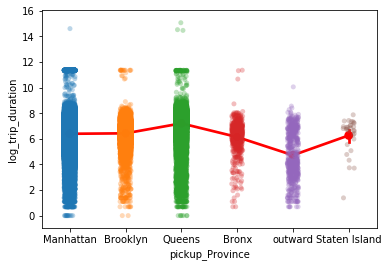

,df,sum_sq,mean_sq,F,PR(>F)
C(pickup_Province),6.0,2.914766e+07,4.857944e+06,8.290232e+06,0.0
Residual,701772.0,4.112272e+05,5.859841e-01,NaN,NaN


In [27]:
Impact_In_Category('pickup_Province', 'log_trip_duration', train)

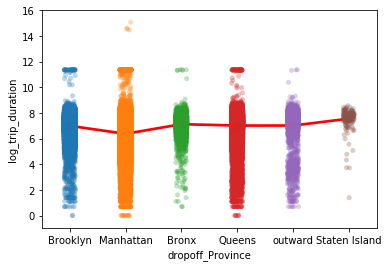

,df,sum_sq,mean_sq,F,PR(>F)
C(dropoff_Province),6.0,2.915057e+07,4.858429e+06,8.350165e+06,0.0
Residual,701772.0,4.083164e+05,5.818363e-01,NaN,NaN


In [28]:
Impact_In_Category('dropoff_Province', 'log_trip_duration', train)

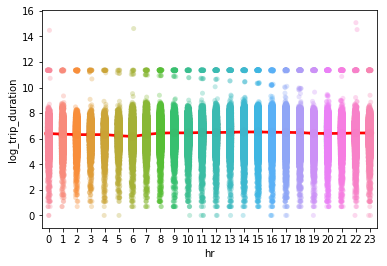

,df,sum_sq,mean_sq,F,PR(>F)
C(hr),24.0,2.912437e+07,1.213515e+06,1.959825e+06,0.0
Residual,701754.0,4.345231e+05,6.191958e-01,NaN,NaN


In [29]:
Impact_In_Category('hr', 'log_trip_duration', train)

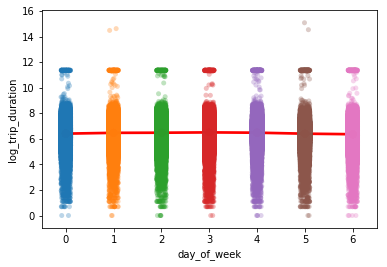

,df,sum_sq,mean_sq,F,PR(>F)
C(day_of_week),7.0,2.912247e+07,4.160353e+06,6.689933e+06,0.0
Residual,701771.0,4.364192e+05,6.218826e-01,NaN,NaN


In [30]:
Impact_In_Category('day_of_week', 'log_trip_duration', train)

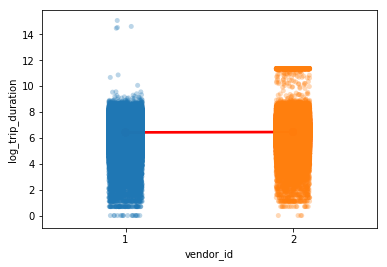

,df,sum_sq,mean_sq,F,PR(>F)
C(vendor_id),2.0,2.912097e+07,1.456049e+07,2.333343e+07,0.0
Residual,701776.0,4.379209e+05,6.240181e-01,NaN,NaN


In [31]:
Impact_In_Category('vendor_id', 'log_trip_duration', train)

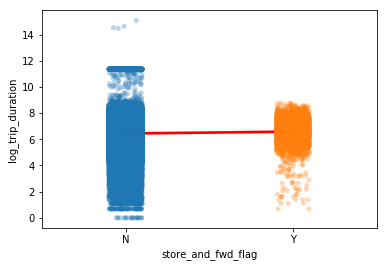

,df,sum_sq,mean_sq,F,PR(>F)
C(store_and_fwd_flag),2.0,2.912089e+07,1.456045e+07,2.332915e+07,0.0
Residual,701776.0,4.380002e+05,6.241310e-01,NaN,NaN


In [32]:
Impact_In_Category('store_and_fwd_flag', 'log_trip_duration', train)

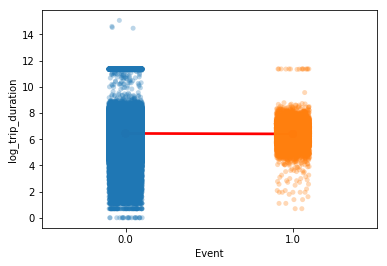

,df,sum_sq,mean_sq,F,PR(>F)
C(Event),2.0,2.912082e+07,1.456041e+07,2.332544e+07,0.0
Residual,701776.0,4.380689e+05,6.242289e-01,NaN,NaN


In [33]:
Impact_In_Category('Event', 'log_trip_duration', train)

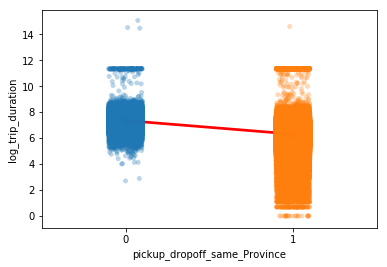

,df,sum_sq,mean_sq,F,PR(>F)
C(pickup_dropoff_same_Province),2.0,2.920487e+07,1.460244e+07,2.894667e+07,0.0
Residual,701776.0,3.540179e+05,5.044600e-01,NaN,NaN


In [34]:
Impact_In_Category('pickup_dropoff_same_Province', 'log_trip_duration', train)

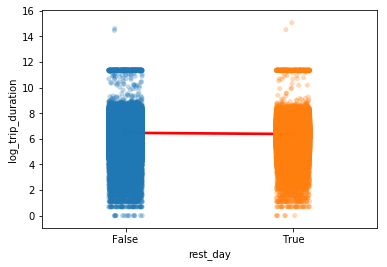

,df,sum_sq,mean_sq,F,PR(>F)
C(rest_day),2.0,2.912217e+07,1.456109e+07,2.339853e+07,0.0
Residual,701776.0,4.367206e+05,6.223076e-01,NaN,NaN


In [35]:
Impact_In_Category('rest_day', 'log_trip_duration', train)

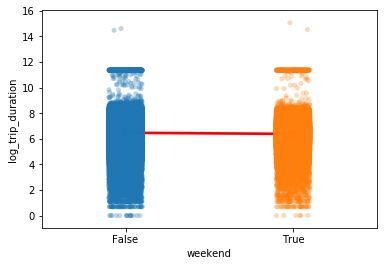

,df,sum_sq,mean_sq,F,PR(>F)
C(weekend),2.0,2.912188e+07,1.456094e+07,2.338297e+07,0.0
Residual,701776.0,4.370070e+05,6.227158e-01,NaN,NaN


In [36]:
Impact_In_Category('weekend', 'log_trip_duration', train)

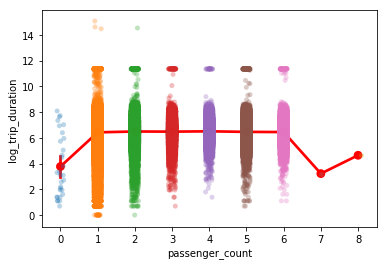

,df,sum_sq,mean_sq,F,PR(>F)
C(passenger_count),9.0,2.912153e+07,3.235726e+06,5.191925e+06,0.0
Residual,701769.0,4.373584e+05,6.232228e-01,NaN,NaN


In [37]:
Impact_In_Category('passenger_count', 'log_trip_duration', train)

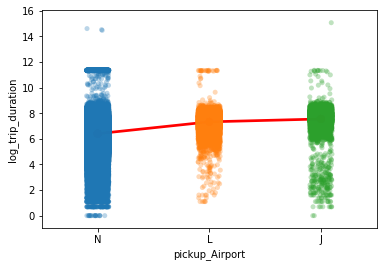

,df,sum_sq,mean_sq,F,PR(>F)
C(pickup_Airport),3.0,2.914640e+07,9.715465e+06,1.652882e+07,0.0
Residual,701775.0,4.124959e+05,5.877893e-01,NaN,NaN


In [38]:
Impact_In_Category('pickup_Airport', 'log_trip_duration', train)

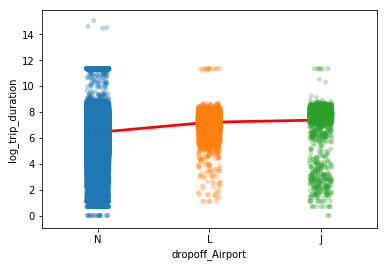

,df,sum_sq,mean_sq,F,PR(>F)
C(dropoff_Airport),3.0,2.912852e+07,9.709507e+06,1.583259e+07,0.0
Residual,701775.0,4.303712e+05,6.132609e-01,NaN,NaN


In [39]:
Impact_In_Category('dropoff_Airport', 'log_trip_duration', train)

In [40]:
x1 = 'hr'
x2 = 'rest_day'
y = 'log_trip_duration'
model = sm.OLS.from_formula("{} ~ C({}):C({}) + 0".format(y, x1, x2), data = train)
sm.stats.anova_lm(model.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(hr):C(rest_day),48.0,2.912842e+07,606842.165887,989248.815779,0.0
Residual,701730.0,4.304674e+05,0.613437,NaN,NaN


In [41]:
x1 = 'hr'
x2 = 'weekend'
y = 'log_trip_duration'
model = sm.OLS.from_formula("{} ~ C({}):C({}) + 0".format(y, x1, x2), data = train)
sm.stats.anova_lm(model.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(hr):C(weekend),48.0,2.912806e+07,606834.482385,988389.475859,0.0
Residual,701730.0,4.308362e+05,0.613963,NaN,NaN


In [42]:
x1 = 'weekend'
x2 = 'rest_day'
y = 'log_trip_duration'
model = sm.OLS.from_formula("{} ~ C({}):C({}) + 0".format(y, x1, x2), data = train)
sm.stats.anova_lm(model.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(weekend):C(rest_day),4.0,2.912219e+07,7.280547e+06,1.169967e+07,0.0
Residual,701775.0,4.367051e+05,6.222865e-01,NaN,NaN


In [43]:
x1 = 'pickup_Province'
x2 = 'dropoff_Province'
y = 'log_trip_duration'
model = sm.OLS.from_formula("{} ~ C({}):C({}) + 0".format(y, x1, x2), data = train)
sm.stats.anova_lm(model.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(pickup_Province):C(dropoff_Province),36.0,2.921038e+07,811399.463866,1.633786e+06,0.0
Residual,701746.0,3.485133e+05,0.496637,NaN,NaN


In [44]:
x1 = 'pickup_Province'
x2 = 'dropoff_Airport'
y = 'log_trip_duration'
model = sm.OLS.from_formula("{} ~ C({}):C({}) + 0".format(y, x1, x2), data = train)
sm.stats.anova_lm(model.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(pickup_Province):C(dropoff_Airport),18.0,2.916306e+07,1.620170e+06,2.872367e+06,0.0
Residual,701761.0,3.958311e+05,5.640539e-01,NaN,NaN


In [45]:
x1 = 'pickup_Airport'
x2 = 'dropoff_Province'
y = 'log_trip_duration'
model = sm.OLS.from_formula("{} ~ C({}):C({}) + 0".format(y, x1, x2), data = train)
sm.stats.anova_lm(model.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(pickup_Airport):C(dropoff_Province),18.0,2.917986e+07,1.621103e+06,3.001367e+06,0.0
Residual,701760.0,3.790357e+05,5.401216e-01,NaN,NaN


In [46]:
x1 = 'pickup_dropoff_same_Province'
x2 = 'dropoff_Province'
y = 'log_trip_duration'
model = sm.OLS.from_formula("{} ~ C({}):C({}) + 0".format(y, x1, x2), data = train)
sm.stats.anova_lm(model.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(pickup_dropoff_same_Province):C(dropoff_Province),12.0,2.920853e+07,2.434044e+06,4.875268e+06,0.0
Residual,701766.0,3.503662e+05,4.992636e-01,NaN,NaN


In [47]:
x1 = 'pickup_dropoff_same_Province'
x2 = 'pickup_Province'
y = 'log_trip_duration'
model = sm.OLS.from_formula("{} ~ C({}):C({}) + 0".format(y, x1, x2), data = train)
sm.stats.anova_lm(model.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(pickup_dropoff_same_Province):C(pickup_Province),12.0,2.920970e+07,2.434142e+06,4.891896e+06,0.0
Residual,701766.0,3.491893e+05,4.975865e-01,NaN,NaN


In [48]:
modelX = 'log_trip_duration ~ C(day_of_week) + C(Event) + C(rest_day) + C(weekend) + C(pickup_Province) + C(dropoff_Province) + C(pickup_dropoff_same_Province) + C(pickup_Airport) + C(dropoff_Airport) + C(day_of_week):C(hr) + C(weekend):C(hr) + C(rest_day):C(hr) + C(weekend):C(rest_day) + C(pickup_Province):C(dropoff_Province) + C(pickup_dropoff_same_Province):C(pickup_Province) + C(pickup_dropoff_same_Province):C(dropoff_Province) + C(pickup_Airport):C(dropoff_Province) + C(dropoff_Airport):C(pickup_Province)'
model = sm.OLS.from_formula(modelX, train)
sm.stats.anova_lm(model.fit())

,df,sum_sq,mean_sq,F,PR(>F)
C(day_of_week),6.0,1664.418146,277.403024,586.148740,0.000000e+00
C(Event),1.0,6.197622,6.197622,13.095488,2.960286e-04
C(rest_day),1.0,199.407021,199.407021,421.344269,1.325704e-93
C(weekend),1.0,0.594207,0.594207,1.255551,2.624953e-01
C(pickup_Province),5.0,27047.470917,5409.494183,11430.186130,0.000000e+00
C(dropoff_Province),5.0,22638.936119,4527.787224,9567.151562,0.000000e+00
C(pickup_dropoff_same_Province),1.0,38953.346465,38953.346465,82307.880442,0.000000e+00
C(pickup_Airport),2.0,1152.660128,576.330064,1217.777426,0.000000e+00
C(dropoff_Airport),2.0,172.506367,86.253183,182.251779,7.406510e-80
C(day_of_week):C(hr),161.0,11180.026397,69.441158,146.728203,0.000000e+00


* 회귀모델을 만들기 위해 독립변수를 선택 (1차)  

> * Numeric
>> * distance -> log(distance + 1)
>> * dropoff_longitude
>> * dropoff_latitude
>> * hour_day_of_week_float

> * Category
>> * pickup_dropoff_same_Province
>> * pickup_Province
>> * dropoff_Province
>> * day_of_week & hr의 interaction

#### Linear Regression

#### 선택한 Fiture를 통해 모델을 만듦

### Model 1st

In [49]:
formulaIs1 = 'I(np.log(trip_duration)) ~ I(np.log(distance + 1)) + hour_day_of_week_float + dropoff_longitude + dropoff_latitude + C(pickup_dropoff_same_Province) + C(hr):C(day_of_week) + C(pickup_Province) + C(dropoff_Province)'
fList1 = ['distance', 'dropoff_longitude', 
         'dropoff_latitude', 'hour_day_of_week_float',
         'pickup_dropoff_same_Province', 'day_of_week',
         'hr', 'pickup_Province', 'dropoff_Province']
modelIs1 = sm.OLS.from_formula(formulaIs1, data=train)
result1 = modelIs1.fit()
result1.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.626
Model:                                  OLS   Adj. R-squared:                  0.626
Method:                       Least Squares   F-statistic:                     6486.
Date:                      Wed, 28 Mar 2018   Prob (F-statistic):               0.00
Time:                              21:44:50   Log-Likelihood:            -4.8541e+05
No. Observations:                    701778   AIC:                         9.712e+05
Df Residuals:                        701596   BIC:                         9.733e+05
Df Model:                               181                                         
Covariance Type:                  nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                              -24.1835      1.441    -16.787      0.000     -27.007     -21.360
C(pickup_dropoff_same_Province)[T.1]     0.0164      0.003      5.452      0.000       0.011       0.022
C(pickup_Province)[T.Brooklyn]          -0.1491      0.021     -7.051      0.000      -0.190      -0.108
C(pickup_Province)[T.Manhattan]         -0.0749      0.021     -3.634      0.000      -0.115      -0.035
C(pickup_Province)[T.Queens]            -0.3646      0.021    -17.503      0.000      -0.405      -0.324
C(pickup_Province)[T.Staten Island]      1.0851      0.097     11.200      0.000       0.895       1.275
C(pickup_Province)[T.outward]           -0.6716      0.030    -22.648      0.000      -0.730      -0.613
C(dropoff_Province)[T.Brooklyn]          0.1516      0.008     17.979      0.000       0.135       0.168
C(dropoff_Province)[T.Manhattan]         0.1576      0.008     19.531      0.000       0.142       0.173
C(dropoff_Province)[T.Queens]            0.0902      0.008     11.039      0.000       0.074       0.106
C(dropoff_Province)[T.Staten Island]    -0.4864      0.039    -12.442      0.000      -0.563      -0.410
C(dropoff_Province)[T.outward]          -0.3159      0.012    -25.456      0.000      -0.340      -0.292
C(day_of_week)[T.1]                     -0.0790      0.014     -5.512      0.000      -0.107      -0.051
C(day_of_week)[T.2]                     -0.1987      0.013    -15.349      0.000      -0.224      -0.173
C(day_of_week)[T.3]                     -0.3282      0.012    -27.607      0.000      -0.352      -0.305
C(day_of_week)[T.4]                     -0.3950      0.010    -38.099      0.000      -0.415      -0.375
C(day_of_week)[T.5]                     -0.4345      0.010    -42.937      0.000      -0.454      -0.415
C(day_of_week)[T.6]                     -0.5778      0.012    -49.505      0.000      -0.601      -0.555
C(hr)[T.1]:C(day_of_week)[0]            -0.0238      0.018     -1.329      0.184      -0.059       0.011
C(hr)[T.2]:C(day_of_week)[0]            -0.0248      0.021     -1.180      0.238      -0.066       0.016
C(hr)[T.3]:C(day_of_week)[0]            -0.0105      0.024     -0.445      0.656      -0.057       0.036
C(hr)[T.4]:C(day_of_week)[0]            -0.1163      0.022     -5.204      0.000      -0.160      -0.073
C(hr)[T.5]:C(day_of_week)[0]            -0.1283      0.019     -6.909      0.000      -0.165      -0.092
C(hr)[T.6]:C(day_of_week)[0]            -0.0294      0.014     -2.101      0.036      -0.057      -0.002
C(hr)[T.7]:C(day_of_week)[0]             0.2148      0.013     17.108      0.000       0.190       0.239
C(hr)[T.8]:C(day_of_week)[0]             0.3997      0.012     33.029      0.

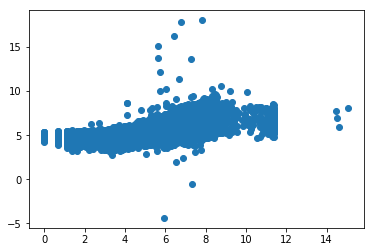

In [50]:
y_new = result1.predict(train[fList1])
y = train.apply(lambda x:np.log(x.trip_duration),axis=1)
plt.scatter(y,y_new)

### model 2nd

In [51]:
formulaIs2 = 'I(np.log(trip_duration)) ~ I(np.log(distance + 1)) + dropoff_longitude + dropoff_latitude + C(pickup_dropoff_same_Province) + C(hr):C(day_of_week) + C(pickup_Province) + C(dropoff_Province)'
fList2 = ['distance', 'dropoff_longitude', 
         'dropoff_latitude', 'hour_day_of_week_float',
         'pickup_dropoff_same_Province', 'day_of_week',
         'hr', 'pickup_Province', 'dropoff_Province']
modelIs2 = sm.OLS.from_formula(formulaIs2, data=train)
result2 = modelIs2.fit()
result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.626
Model:                                  OLS   Adj. R-squared:                  0.626
Method:                       Least Squares   F-statistic:                     6486.
Date:                      Wed, 28 Mar 2018   Prob (F-statistic):               0.00
Time:                              21:46:08   Log-Likelihood:            -4.8541e+05
No. Observations:                    701778   AIC:                         9.712e+05
Df Residuals:                        701596   BIC:                         9.733e+05
Df Model:                               181                                         
Covariance Type:                  nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                              -24.1835      1.441    -16.787      0.000     -27.007     -21.360
C(pickup_dropoff_same_Province)[T.1]     0.0164      0.003      5.452      0.000       0.011       0.022
C(pickup_Province)[T.Brooklyn]          -0.1491      0.021     -7.051      0.000      -0.190      -0.108
C(pickup_Province)[T.Manhattan]         -0.0749      0.021     -3.634      0.000      -0.115      -0.035
C(pickup_Province)[T.Queens]            -0.3646      0.021    -17.503      0.000      -0.405      -0.324
C(pickup_Province)[T.Staten Island]      1.0851      0.097     11.200      0.000       0.895       1.275
C(pickup_Province)[T.outward]           -0.6716      0.030    -22.648      0.000      -0.730      -0.613
C(dropoff_Province)[T.Brooklyn]          0.1516      0.008     17.979      0.000       0.135       0.168
C(dropoff_Province)[T.Manhattan]         0.1576      0.008     19.531      0.000       0.142       0.173
C(dropoff_Province)[T.Queens]            0.0902      0.008     11.039      0.000       0.074       0.106
C(dropoff_Province)[T.Staten Island]    -0.4864      0.039    -12.442      0.000      -0.563      -0.410
C(dropoff_Province)[T.outward]          -0.3159      0.012    -25.456      0.000      -0.340      -0.292
C(day_of_week)[T.1]                      0.0639      0.015      4.184      0.000       0.034       0.094
C(day_of_week)[T.2]                      0.0870      0.015      5.933      0.000       0.058       0.116
C(day_of_week)[T.3]                      0.1004      0.014      7.102      0.000       0.073       0.128
C(day_of_week)[T.4]                      0.1764      0.013     13.480      0.000       0.151       0.202
C(day_of_week)[T.5]                      0.2798      0.012     22.468      0.000       0.255       0.304
C(day_of_week)[T.6]                      0.2793      0.013     22.335      0.000       0.255       0.304
C(hr)[T.1]:C(day_of_week)[0]            -0.0178      0.018     -0.993      0.321      -0.053       0.017
C(hr)[T.2]:C(day_of_week)[0]            -0.0129      0.021     -0.612      0.541      -0.054       0.029
C(hr)[T.3]:C(day_of_week)[0]             0.0073      0.024      0.308      0.758      -0.039       0.054
C(hr)[T.4]:C(day_of_week)[0]            -0.0925      0.023     -4.104      0.000      -0.137      -0.048
C(hr)[T.5]:C(day_of_week)[0]            -0.0985      0.019     -5.226      0.000      -0.136      -0.062
C(hr)[T.6]:C(day_of_week)[0]             0.0063      0.014      0.437      0.662      -0.022       0.035
C(hr)[T.7]:C(day_of_week)[0]             0.2565      0.013     19.537      0.000       0.231       0.282
C(hr)[T.8]:C(day_of_week)[0]             0.4473      0.013     35.025      0.

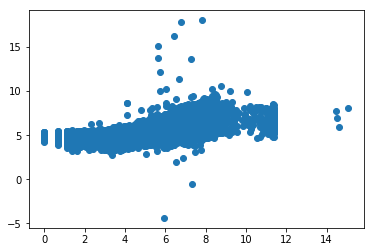

In [52]:
y_new2 = result2.predict(train[fList2])
y2 = train.apply(lambda x:np.log(x.trip_duration),axis=1)
plt.scatter(y2,y_new2)

### model 3rd

In [53]:
formulaIs3 = 'I(np.log(trip_duration)) ~ I(np.log(distance + 1))  + C(pickup_dropoff_same_Province) + C(hr):C(day_of_week) + C(pickup_Province) + C(dropoff_Province)'
fList3 = ['distance', 
         'pickup_dropoff_same_Province', 'day_of_week',
         'hr', 'pickup_Province', 'dropoff_Province']
modelIs3 = sm.OLS.from_formula(formulaIs3, data=train)
result3 = modelIs3.fit()
result3.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.623
Model:                                  OLS   Adj. R-squared:                  0.622
Method:                       Least Squares   F-statistic:                     6466.
Date:                      Wed, 28 Mar 2018   Prob (F-statistic):               0.00
Time:                              21:47:37   Log-Likelihood:            -4.8852e+05
No. Observations:                    701778   AIC:                         9.774e+05
Df Residuals:                        701598   BIC:                         9.795e+05
Df Model:                               179                                         
Covariance Type:                  nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                4.5293      0.023    195.495      0.000       4.484       4.575
C(pickup_dropoff_same_Province)[T.1]     0.0080      0.003      2.634      0.008       0.002       0.014
C(pickup_Province)[T.Brooklyn]          -0.1193      0.021     -5.622      0.000      -0.161      -0.078
C(pickup_Province)[T.Manhattan]         -0.0508      0.021     -2.454      0.014      -0.091      -0.010
C(pickup_Province)[T.Queens]            -0.3431      0.021    -16.397      0.000      -0.384      -0.302
C(pickup_Province)[T.Staten Island]      1.0741      0.097     11.037      0.000       0.883       1.265
C(pickup_Province)[T.outward]           -0.6460      0.030    -21.705      0.000      -0.704      -0.588
C(dropoff_Province)[T.Brooklyn]          0.3507      0.008     44.010      0.000       0.335       0.366
C(dropoff_Province)[T.Manhattan]         0.3117      0.008     39.648      0.000       0.296       0.327
C(dropoff_Province)[T.Queens]            0.1669      0.008     20.968      0.000       0.151       0.182
C(dropoff_Province)[T.Staten Island]    -0.0736      0.039     -1.892      0.059      -0.150       0.003
C(dropoff_Province)[T.outward]          -0.0995      0.012     -8.189      0.000      -0.123      -0.076
C(day_of_week)[T.1]                      0.0617      0.015      4.023      0.000       0.032       0.092
C(day_of_week)[T.2]                      0.0857      0.015      5.816      0.000       0.057       0.115
C(day_of_week)[T.3]                      0.1003      0.014      7.064      0.000       0.072       0.128
C(day_of_week)[T.4]                      0.1777      0.013     13.522      0.000       0.152       0.204
C(day_of_week)[T.5]                      0.2837      0.013     22.679      0.000       0.259       0.308
C(day_of_week)[T.6]                      0.2841      0.013     22.623      0.000       0.260       0.309
C(hr)[T.1]:C(day_of_week)[0]            -0.0192      0.018     -1.066      0.286      -0.055       0.016
C(hr)[T.2]:C(day_of_week)[0]            -0.0149      0.021     -0.703      0.482      -0.057       0.027
C(hr)[T.3]:C(day_of_week)[0]             0.0027      0.024      0.115      0.908      -0.044       0.050
C(hr)[T.4]:C(day_of_week)[0]            -0.0959      0.023     -4.235      0.000      -0.140      -0.052
C(hr)[T.5]:C(day_of_week)[0]            -0.0990      0.019     -5.227      0.000      -0.136      -0.062
C(hr)[T.6]:C(day_of_week)[0]             0.0057      0.015      0.391      0.696      -0.023       0.034
C(hr)[T.7]:C(day_of_week)[0]             0.2558      0.013     19.395      0.000       0.230       0.282
C(hr)[T.8]:C(day_of_week)[0]             0.4499      0.013     35.067      0.

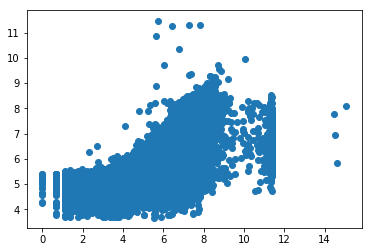

In [54]:
y_new3 = result3.predict(train[fList3])
y3 = train.apply(lambda x:np.log(x.trip_duration),axis=1)
plt.scatter(y3,y_new3)

### Model 4th

In [55]:
formulaIs4 = 'I(np.log(trip_duration)) ~ I(np.log(distance+1))+ C(pickup_dropoff_same_Province) + C(dropoff_Province):C(pickup_Province)+C(hr):C(day_of_week)'
fList4 = ['distance','pickup_Province', 'dropoff_Province',  'hr','day_of_week', 'pickup_dropoff_same_Province']
model4 = sm.OLS.from_formula(formulaIs4, data=train)
result4 = model4.fit()
result4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.623
Model:                                  OLS   Adj. R-squared:                  0.623
Method:                       Least Squares   F-statistic:                     5803.
Date:                      Wed, 28 Mar 2018   Prob (F-statistic):               0.00
Time:                              21:49:06   Log-Likelihood:            -4.8792e+05
No. Observations:                    701778   AIC:                         9.762e+05
Df Residuals:                        701577   BIC:                         9.785e+05
Df Model:                               200                                         
Covariance Type:                  nonrobust                                         
==========================================================================================================================================
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                              -2.784e+08   5.33e+08     -0.522      0.601   -1.32e+09    7.66e+08
C(pickup_dropoff_same_Province)[T.1]                                    2.784e+08   5.33e+08      0.522      0.601   -7.66e+08    1.32e+09
C(pickup_Province)[T.Brooklyn]                                          2.784e+08   5.33e+08      0.522      0.601   -7.66e+08    1.32e+09
C(pickup_Province)[T.Manhattan]                                         2.784e+08   5.33e+08      0.522      0.601   -7.66e+08    1.32e+09
C(pickup_Province)[T.Queens]                                            2.784e+08   5.33e+08      0.522      0.601   -7.66e+08    1.32e+09
C(pickup_Province)[T.Staten Island]                                     1.671e+08    3.2e+08      0.522      0.601    -4.6e+08    7.94e+08
C(pickup_Province)[T.outward]                                           2.784e+08   5.33e+08      0.522      0.601   -7.66e+08    1.32e+09
C(dropoff_Province)[T.Brooklyn]:C(pickup_Province)[Bronx]               2.784e+08   5.33e+08      0.522      0.601   -7.66e+08    1.32e+09
C(dropoff_Province)[T.Manhattan]:C(pickup_Province)[Bronx]              2.784e+08   5.33e+08      0.522      0.601   -7.66e+08    1.32e+09
C(dropoff_Province)[T.Queens]:C(pickup_Province)[Bronx]                 2.784e+08   5.33e+08      0.522      0.601   -7.66e+08    1.32e+09
C(dropoff_Province)[T.Staten Island]:C(pickup_Province)[Bronx]           4.96e+04    9.5e+04      0.522      0.601   -1.37e+05    2.36e+05
C(dropoff_Province)[T.outward]:C(pickup_Province)[Bronx]                2.784e+08   5.33e+08      0.522      0.601   -7.66e+08    1.32e+09
C(dropoff_Province)[T.Brooklyn]:C(pickup_Province)[Brooklyn]           -2.784e+08   5.33e+08     -0.522      0.601   -1.32e+09    7.66e+08
C(dropoff_Province)[T.Manhattan]:C(pickup_Province)[Brooklyn]              0.4888      0.089      5.493      0.000       0.314       0.663
C(dropoff_Province)[T.Queens]:C(pickup_Province)[Brooklyn]                 0.2570      0.090      2.843      0.004       0.080       0.434
C(dropoff_Province)[T.Staten Island]:C(pickup_Province)[Brooklyn]          0.4272      0.354      1.206      0.228      -0.267       1.122
C(dropoff_Province)[T.outward]:C(pickup_Province)[Brooklyn]                0.0806      0.133      0.606      0.544      -0.180       0.341
C(dropoff_Province)[T.Brooklyn]:C(pickup_Province)[Manhattan]              0.4229      0.009     47.543      0.000       0.405       0.440
C(dropoff_Province)[T.Manhattan]:C(pickup_Province)[Manhattan]         -2.784e+08   5.33e+08     -

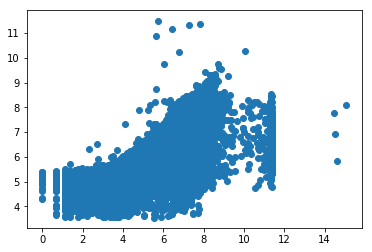

In [56]:
y_new4 = result4.predict(train[fList4])
y4 = train.apply(lambda x:np.log(x.trip_duration),axis=1)
plt.scatter(y4,y_new4)

### Model 5th

In [57]:
formulaIs5 = 'I(np.log(trip_duration)) ~ I(np.log(distance + 0.1)) + hour_day_of_week_float + dropoff_longitude + dropoff_latitude + C(pickup_dropoff_same_Province) + C(hr):C(day_of_week) + C(pickup_Province) + C(dropoff_Province)'
fList5 = ['distance', 'dropoff_longitude', 
         'dropoff_latitude', 'hour_day_of_week_float',
         'pickup_dropoff_same_Province', 'day_of_week',
         'hr', 'pickup_Province', 'dropoff_Province']
modelIs5 = sm.OLS.from_formula(formulaIs5, data=train)
result5 = modelIs5.fit()
result5.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.643
Model:                                  OLS   Adj. R-squared:                  0.643
Method:                       Least Squares   F-statistic:                     6983.
Date:                      Wed, 28 Mar 2018   Prob (F-statistic):               0.00
Time:                              21:50:28   Log-Likelihood:            -4.6896e+05
No. Observations:                    701778   AIC:                         9.383e+05
Df Residuals:                        701596   BIC:                         9.404e+05
Df Model:                               181                                         
Covariance Type:                  nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.9061      1.405      0.645      0.519      -1.848       3.661
C(pickup_dropoff_same_Province)[T.1]    -0.0801      0.003    -27.805      0.000      -0.086      -0.074
C(pickup_Province)[T.Brooklyn]          -0.2187      0.021    -10.588      0.000      -0.259      -0.178
C(pickup_Province)[T.Manhattan]         -0.1558      0.020     -7.734      0.000      -0.195      -0.116
C(pickup_Province)[T.Queens]            -0.3077      0.020    -15.125      0.000      -0.348      -0.268
C(pickup_Province)[T.Staten Island]      1.6390      0.095     17.316      0.000       1.454       1.825
C(pickup_Province)[T.outward]           -0.2844      0.029     -9.813      0.000      -0.341      -0.228
C(dropoff_Province)[T.Brooklyn]          0.0504      0.008      6.126      0.000       0.034       0.067
C(dropoff_Province)[T.Manhattan]         0.0704      0.008      8.934      0.000       0.055       0.086
C(dropoff_Province)[T.Queens]            0.0411      0.008      5.149      0.000       0.025       0.057
C(dropoff_Province)[T.Staten Island]    -0.3062      0.038     -8.018      0.000      -0.381      -0.231
C(dropoff_Province)[T.outward]          -0.1972      0.012    -16.279      0.000      -0.221      -0.173
C(day_of_week)[T.1]                     -0.0806      0.014     -5.757      0.000      -0.108      -0.053
C(day_of_week)[T.2]                     -0.1919      0.013    -15.182      0.000      -0.217      -0.167
C(day_of_week)[T.3]                     -0.3214      0.012    -27.677      0.000      -0.344      -0.299
C(day_of_week)[T.4]                     -0.3842      0.010    -37.934      0.000      -0.404      -0.364
C(day_of_week)[T.5]                     -0.4272      0.010    -43.217      0.000      -0.447      -0.408
C(day_of_week)[T.6]                     -0.5718      0.011    -50.148      0.000      -0.594      -0.549
C(hr)[T.1]:C(day_of_week)[0]            -0.0315      0.017     -1.805      0.071      -0.066       0.003
C(hr)[T.2]:C(day_of_week)[0]            -0.0150      0.021     -0.728      0.467      -0.055       0.025
C(hr)[T.3]:C(day_of_week)[0]             0.0005      0.023      0.021      0.983      -0.045       0.046
C(hr)[T.4]:C(day_of_week)[0]            -0.1009      0.022     -4.620      0.000      -0.144      -0.058
C(hr)[T.5]:C(day_of_week)[0]            -0.1200      0.018     -6.617      0.000      -0.156      -0.084
C(hr)[T.6]:C(day_of_week)[0]            -0.0347      0.014     -2.540      0.011      -0.062      -0.008
C(hr)[T.7]:C(day_of_week)[0]             0.2073      0.012     16.895      0.000       0.183       0.231
C(hr)[T.8]:C(day_of_week)[0]             0.3907      0.012     33.050      0.

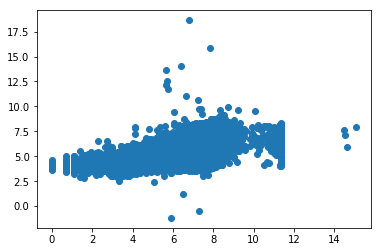

In [58]:
y_new5 = result5.predict(train[fList5])
y5 = train.apply(lambda x:np.log(x.trip_duration),axis=1)
plt.scatter(y5,y_new5)

### Model 6th

In [59]:
formulaIs6 = 'I(np.log(trip_duration)) ~ I(np.log(distance + 0.1)) + dropoff_longitude + dropoff_latitude + C(pickup_dropoff_same_Province) + C(hr):C(day_of_week) + C(pickup_Province) + C(dropoff_Province)'
fList6 = ['distance', 'dropoff_longitude', 
         'dropoff_latitude', 'hour_day_of_week_float',
         'pickup_dropoff_same_Province', 'day_of_week',
         'hr', 'pickup_Province', 'dropoff_Province']
modelIs6 = sm.OLS.from_formula(formulaIs6, data=train)
result6 = modelIs6.fit()
result6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.643
Model:                                  OLS   Adj. R-squared:                  0.643
Method:                       Least Squares   F-statistic:                     6983.
Date:                      Wed, 28 Mar 2018   Prob (F-statistic):               0.00
Time:                              21:51:47   Log-Likelihood:            -4.6896e+05
No. Observations:                    701778   AIC:                         9.383e+05
Df Residuals:                        701596   BIC:                         9.404e+05
Df Model:                               181                                         
Covariance Type:                  nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                0.9061      1.405      0.645      0.519      -1.848       3.661
C(pickup_dropoff_same_Province)[T.1]    -0.0801      0.003    -27.805      0.000      -0.086      -0.074
C(pickup_Province)[T.Brooklyn]          -0.2187      0.021    -10.588      0.000      -0.259      -0.178
C(pickup_Province)[T.Manhattan]         -0.1558      0.020     -7.734      0.000      -0.195      -0.116
C(pickup_Province)[T.Queens]            -0.3077      0.020    -15.125      0.000      -0.348      -0.268
C(pickup_Province)[T.Staten Island]      1.6390      0.095     17.316      0.000       1.454       1.825
C(pickup_Province)[T.outward]           -0.2844      0.029     -9.813      0.000      -0.341      -0.228
C(dropoff_Province)[T.Brooklyn]          0.0504      0.008      6.126      0.000       0.034       0.067
C(dropoff_Province)[T.Manhattan]         0.0704      0.008      8.934      0.000       0.055       0.086
C(dropoff_Province)[T.Queens]            0.0411      0.008      5.149      0.000       0.025       0.057
C(dropoff_Province)[T.Staten Island]    -0.3062      0.038     -8.018      0.000      -0.381      -0.231
C(dropoff_Province)[T.outward]          -0.1972      0.012    -16.279      0.000      -0.221      -0.173
C(day_of_week)[T.1]                      0.0599      0.015      4.015      0.000       0.031       0.089
C(day_of_week)[T.2]                      0.0890      0.014      6.207      0.000       0.061       0.117
C(day_of_week)[T.3]                      0.0999      0.014      7.240      0.000       0.073       0.127
C(day_of_week)[T.4]                      0.1776      0.013     13.894      0.000       0.153       0.203
C(day_of_week)[T.5]                      0.2751      0.012     22.612      0.000       0.251       0.299
C(day_of_week)[T.6]                      0.2709      0.012     22.180      0.000       0.247       0.295
C(hr)[T.1]:C(day_of_week)[0]            -0.0257      0.018     -1.465      0.143      -0.060       0.009
C(hr)[T.2]:C(day_of_week)[0]            -0.0033      0.021     -0.158      0.875      -0.044       0.037
C(hr)[T.3]:C(day_of_week)[0]             0.0180      0.023      0.777      0.437      -0.027       0.064
C(hr)[T.4]:C(day_of_week)[0]            -0.0775      0.022     -3.518      0.000      -0.121      -0.034
C(hr)[T.5]:C(day_of_week)[0]            -0.0908      0.018     -4.928      0.000      -0.127      -0.055
C(hr)[T.6]:C(day_of_week)[0]             0.0004      0.014      0.027      0.978      -0.027       0.028
C(hr)[T.7]:C(day_of_week)[0]             0.2482      0.013     19.354      0.000       0.223       0.273
C(hr)[T.8]:C(day_of_week)[0]             0.4375      0.012     35.069      0.

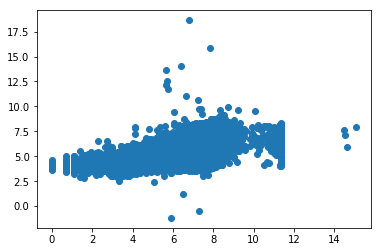

In [60]:
y_new6 = result6.predict(train[fList6])
y6 = train.apply(lambda x:np.log(x.trip_duration),axis=1)
plt.scatter(y6,y_new6)

### Model 7th

In [61]:
formulaIs7 = 'I(np.log(trip_duration)) ~ I(np.log(distance + 0.1))  + C(pickup_dropoff_same_Province) + C(hr):C(day_of_week) + C(pickup_Province) + C(dropoff_Province)'
fList7 = ['distance', 
         'pickup_dropoff_same_Province', 'day_of_week',
         'hr', 'pickup_Province', 'dropoff_Province']
modelIs7 = sm.OLS.from_formula(formulaIs7, data=train)
result7 = modelIs7.fit()
result7.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.640
Model:                                  OLS   Adj. R-squared:                  0.640
Method:                       Least Squares   F-statistic:                     6969.
Date:                      Wed, 28 Mar 2018   Prob (F-statistic):               0.00
Time:                              21:53:04   Log-Likelihood:            -4.7192e+05
No. Observations:                    701778   AIC:                         9.442e+05
Df Residuals:                        701598   BIC:                         9.463e+05
Df Model:                               179                                         
Covariance Type:                  nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                5.4808      0.023    243.179      0.000       5.437       5.525
C(pickup_dropoff_same_Province)[T.1]    -0.0860      0.003    -29.719      0.000      -0.092      -0.080
C(pickup_Province)[T.Brooklyn]          -0.1894      0.021     -9.134      0.000      -0.230      -0.149
C(pickup_Province)[T.Manhattan]         -0.1328      0.020     -6.563      0.000      -0.172      -0.093
C(pickup_Province)[T.Queens]            -0.2874      0.020    -14.068      0.000      -0.327      -0.247
C(pickup_Province)[T.Staten Island]      1.6309      0.095     17.158      0.000       1.445       1.817
C(pickup_Province)[T.outward]           -0.2438      0.029     -8.383      0.000      -0.301      -0.187
C(dropoff_Province)[T.Brooklyn]          0.2576      0.008     33.120      0.000       0.242       0.273
C(dropoff_Province)[T.Manhattan]         0.2179      0.008     28.395      0.000       0.203       0.233
C(dropoff_Province)[T.Queens]            0.1405      0.008     18.076      0.000       0.125       0.156
C(dropoff_Province)[T.Staten Island]     0.0892      0.038      2.346      0.019       0.015       0.164
C(dropoff_Province)[T.outward]           0.0009      0.012      0.076      0.940      -0.022       0.024
C(day_of_week)[T.1]                      0.0579      0.015      3.865      0.000       0.029       0.087
C(day_of_week)[T.2]                      0.0879      0.014      6.104      0.000       0.060       0.116
C(day_of_week)[T.3]                      0.1002      0.014      7.228      0.000       0.073       0.127
C(day_of_week)[T.4]                      0.1790      0.013     13.945      0.000       0.154       0.204
C(day_of_week)[T.5]                      0.2795      0.012     22.877      0.000       0.256       0.303
C(day_of_week)[T.6]                      0.2760      0.012     22.505      0.000       0.252       0.300
C(hr)[T.1]:C(day_of_week)[0]            -0.0271      0.018     -1.539      0.124      -0.062       0.007
C(hr)[T.2]:C(day_of_week)[0]            -0.0051      0.021     -0.247      0.805      -0.046       0.036
C(hr)[T.3]:C(day_of_week)[0]             0.0140      0.023      0.600      0.549      -0.032       0.060
C(hr)[T.4]:C(day_of_week)[0]            -0.0797      0.022     -3.602      0.000      -0.123      -0.036
C(hr)[T.5]:C(day_of_week)[0]            -0.0893      0.018     -4.830      0.000      -0.126      -0.053
C(hr)[T.6]:C(day_of_week)[0]             0.0008      0.014      0.055      0.956      -0.027       0.029
C(hr)[T.7]:C(day_of_week)[0]             0.2485      0.013     19.294      0.000       0.223       0.274
C(hr)[T.8]:C(day_of_week)[0]             0.4407      0.013     35.179      0.

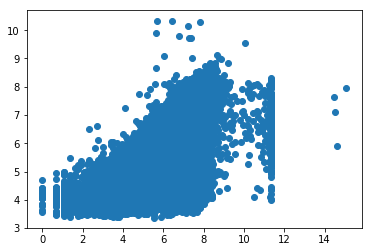

In [62]:
y_new7 = result7.predict(train[fList7])
y7 = train.apply(lambda x:np.log(x.trip_duration),axis=1)
plt.scatter(y7,y_new7)

### Model 8th

In [63]:
formulaIs8 = 'I(np.log(trip_duration)) ~ I(np.log(distance+0.1))+ C(pickup_dropoff_same_Province) + C(dropoff_Province):C(pickup_Province)+C(hr):C(day_of_week)'
fList8 = ['distance','pickup_Province', 'dropoff_Province',  'hr','day_of_week', 'pickup_dropoff_same_Province']
model8 = sm.OLS.from_formula(formulaIs8, data=train)
result8 = model8.fit()
result8.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.640
Model:                                  OLS   Adj. R-squared:                  0.640
Method:                       Least Squares   F-statistic:                     6246.
Date:                      Wed, 28 Mar 2018   Prob (F-statistic):               0.00
Time:                              21:54:37   Log-Likelihood:            -4.7159e+05
No. Observations:                    701778   AIC:                         9.436e+05
Df Residuals:                        701577   BIC:                         9.459e+05
Df Model:                               200                                         
Covariance Type:                  nonrobust                                         
==========================================================================================================================================
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                              -2.237e+08   5.21e+08     -0.430      0.668   -1.24e+09    7.97e+08
C(pickup_dropoff_same_Province)[T.1]                                    2.237e+08   5.21e+08      0.430      0.668   -7.97e+08    1.24e+09
C(pickup_Province)[T.Brooklyn]                                          2.237e+08   5.21e+08      0.430      0.668   -7.97e+08    1.24e+09
C(pickup_Province)[T.Manhattan]                                         2.237e+08   5.21e+08      0.430      0.668   -7.97e+08    1.24e+09
C(pickup_Province)[T.Queens]                                            2.237e+08   5.21e+08      0.430      0.668   -7.97e+08    1.24e+09
C(pickup_Province)[T.Staten Island]                                     1.342e+08   3.13e+08      0.430      0.668   -4.78e+08    7.47e+08
C(pickup_Province)[T.outward]                                           2.237e+08   5.21e+08      0.430      0.668   -7.97e+08    1.24e+09
C(dropoff_Province)[T.Brooklyn]:C(pickup_Province)[Bronx]               2.237e+08   5.21e+08      0.430      0.668   -7.97e+08    1.24e+09
C(dropoff_Province)[T.Manhattan]:C(pickup_Province)[Bronx]              2.237e+08   5.21e+08      0.430      0.668   -7.97e+08    1.24e+09
C(dropoff_Province)[T.Queens]:C(pickup_Province)[Bronx]                 2.237e+08   5.21e+08      0.430      0.668   -7.97e+08    1.24e+09
C(dropoff_Province)[T.Staten Island]:C(pickup_Province)[Bronx]          3.495e+04   8.14e+04      0.430      0.668   -1.25e+05    1.94e+05
C(dropoff_Province)[T.outward]:C(pickup_Province)[Bronx]                2.237e+08   5.21e+08      0.430      0.668   -7.97e+08    1.24e+09
C(dropoff_Province)[T.Brooklyn]:C(pickup_Province)[Brooklyn]           -2.237e+08   5.21e+08     -0.430      0.668   -1.24e+09    7.97e+08
C(dropoff_Province)[T.Manhattan]:C(pickup_Province)[Brooklyn]              0.2141      0.087      2.462      0.014       0.044       0.384
C(dropoff_Province)[T.Queens]:C(pickup_Province)[Brooklyn]                 0.0632      0.088      0.715      0.474      -0.110       0.236
C(dropoff_Province)[T.Staten Island]:C(pickup_Province)[Brooklyn]          0.4104      0.346      1.186      0.236      -0.268       1.089
C(dropoff_Province)[T.outward]:C(pickup_Province)[Brooklyn]                0.0390      0.130      0.300      0.764      -0.215       0.293
C(dropoff_Province)[T.Brooklyn]:C(pickup_Province)[Manhattan]              0.3156      0.009     36.340      0.000       0.299       0.333
C(dropoff_Province)[T.Manhattan]:C(pickup_Province)[Manhattan]         -2.237e+08   5.21e+08     -

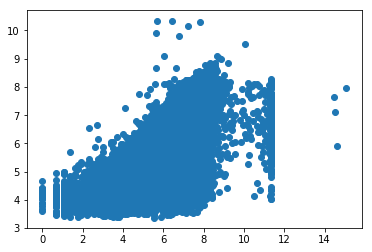

In [64]:
y_new8 = result8.predict(train[fList8])
y8 = train.apply(lambda x:np.log(x.trip_duration),axis=1)
plt.scatter(y8,y_new8)

* 모델5, 모델6의 성능이 좀더 나은 것으로 판단

#### Cross Validation을 통한 모델 검증

In [65]:
cv = KFold(n_splits=5, shuffle=True, random_state=0)

778734.9310584964, 780780.2885781358, -389185.4655292482, 0.6249478444833789, 0.6248268900963991, 2176646207084480.2
0.476852793404
774393.4483045168, 776438.8058241563, -387014.7241522584, 0.6269065315524875, 0.6267862088424366, 2251799813685420.5
0.484325167534
777441.455749956, 779486.8132695954, -388538.727874978, 0.6266454549776255, 0.6265250480703326, 2251799813685254.5
0.479275375654
777898.5182751426, 779943.8761189586, -388767.2591375713, 0.6254417767037111, 0.625320981825189, 1514713321768136.0
0.478309563607
776234.9678678206, 778280.3257116366, -387935.4839339103, 0.6259389388304868, 0.6258183042865535, 1831229069237652.0
0.480288086615


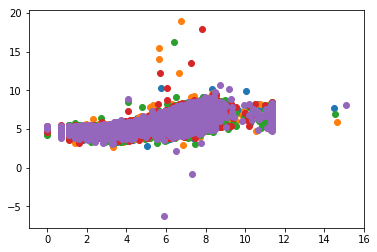

In [66]:
for train_index, test_index in cv.split(train):
    cTrainDe = train.loc[train_index][fList1+['trip_duration']]
    modelc = sm.OLS.from_formula(formulaIs1,cTrainDe)
    resultc = modelc.fit()
    x = '{}, {}, {}, {}, {}, {}'.format(resultc.aic,resultc.bic,resultc.llf, resultc.rsquared, resultc.rsquared_adj, resultc.condition_number)
    print (x)
    cTest = train.loc[test_index][fList1+['trip_duration']]
    yc_new = resultc.predict(cTest[fList1])
    yc_newis = np.exp(yc_new)
    rmsleIs = rmsle(cTest['trip_duration'],yc_newis)
    print (rmsleIs)
    yc = train.loc[test_index].apply(lambda x:np.log(x.trip_duration),axis=1)
    plt.scatter(yc,yc_new) 

778734.931058496, 780780.2885781354, -389185.465529248, 0.6249478444833796, 0.6248268900963998, 199912.19033328953
0.476852793404
774393.4483045167, 776438.8058241562, -387014.72415225836, 0.6269065315524873, 0.6267862088424364, 222032.56770141592
0.484325167534
777441.455749956, 779486.8132695954, -388538.727874978, 0.6266454549776254, 0.6265250480703326, 206824.72503178607
0.479275375654
777898.5182751429, 779943.8761189588, -388767.25913757144, 0.6254417767037108, 0.6253209818251887, 209282.5202246046
0.478309563607
776234.9678678206, 778280.3257116366, -387935.4839339103, 0.6259389388304869, 0.6258183042865535, 220528.28611707737
0.480288086615


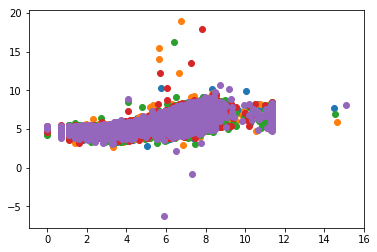

In [67]:
for train_index, test_index in cv.split(train):
    cTrainDe = train.loc[train_index][fList2+['trip_duration']]
    modelc = sm.OLS.from_formula(formulaIs2,cTrainDe)
    resultc = modelc.fit()
    x = '{}, {}, {}, {}, {}, {}'.format(resultc.aic,resultc.bic,resultc.llf, resultc.rsquared, resultc.rsquared_adj, resultc.condition_number)
    print (x)
    cTest = train.loc[test_index][fList2+['trip_duration']]
    yc_new = resultc.predict(cTest[fList2])
    yc_newis = np.exp(yc_new)
    rmsleIs = rmsle(cTest['trip_duration'],yc_newis)
    print (rmsleIs)
    yc = train.loc[test_index].apply(lambda x:np.log(x.trip_duration),axis=1)
    plt.scatter(yc,yc_new) 

783199.040007738, 785221.9210711177, -391419.520003869, 0.6219510613346669, 0.6218304881059686, 382.8227444397254
0.479774266271
779946.8191468073, 781969.700210187, -389793.40957340365, 0.6231950367677008, 0.6230748602869338, 419.00975414082257
0.485396114458
782303.5069697397, 784326.3880331194, -390971.75348486984, 0.623395389234637, 0.623275276653385, 381.8380641705981
0.481601548231
782814.9865172016, 784837.8679011954, -391227.4932586008, 0.6221446161304958, 0.6220241048480162, 379.0340296740435
0.480548314389
781498.1714086168, 783521.0527926106, -390569.0857043084, 0.622413028653324, 0.6222926029769751, 390.7431929299002
0.482789753801


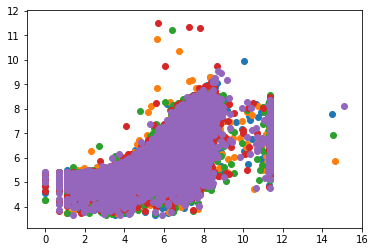

In [68]:
for train_index, test_index in cv.split(train):
    cTrainDe = train.loc[train_index][fList3+['trip_duration']]
    modelc = sm.OLS.from_formula(formulaIs3,cTrainDe)
    resultc = modelc.fit()
    x = '{}, {}, {}, {}, {}, {}'.format(resultc.aic,resultc.bic,resultc.llf, resultc.rsquared, resultc.rsquared_adj, resultc.condition_number)
    print (x)
    cTest = train.loc[test_index][fList3+['trip_duration']]
    yc_new = resultc.predict(cTest[fList3])
    yc_newis = np.exp(yc_new)
    rmsleIs = rmsle(cTest['trip_duration'],yc_newis)
    print (rmsleIs)
    yc = train.loc[test_index].apply(lambda x:np.log(x.trip_duration),axis=1)
    plt.scatter(yc,yc_new) 

782201.1917570939, 784460.0756112012, -390899.59587854694, 0.6226506236886643, 0.622516149256556, 2.8543896539966204e+16
0.47950517804
779069.1658322781, 781305.5732301256, -389335.58291613904, 0.6238090873541926, 0.6236763668478986, 4.721336199816473e+16
0.48571317658
781369.4775436235, 783628.3613977309, -390483.73877181177, 0.6240495457365589, 0.6239155698324985, 1.3454184264424574e+16
0.481217205149
781897.0710500869, 784144.7170323022, -390748.53552504344, 0.6227887737523443, 0.6226550211548505, 4.725797127838269e+16
inf
780616.2117248507, 782875.0959369771, -390107.10586242535, 0.6230339298563761, 0.6228995922608636, 1.29029497464963e+16
0.482324630956


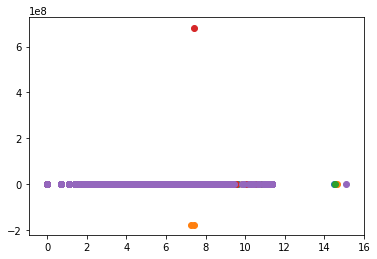

In [69]:
for train_index, test_index in cv.split(train):
    cTrainDe = train.loc[train_index][fList4+['trip_duration']]
    modelc = sm.OLS.from_formula(formulaIs4,cTrainDe)
    resultc = modelc.fit()
    x = '{}, {}, {}, {}, {}, {}'.format(resultc.aic,resultc.bic,resultc.llf, resultc.rsquared, resultc.rsquared_adj, resultc.condition_number)
    print (x)
    cTest = train.loc[test_index][fList4+['trip_duration']]
    yc_new = resultc.predict(cTest[fList4])
    yc_newis = np.exp(yc_new)
    rmsleIs = rmsle(cTest['trip_duration'],yc_newis)
    print (rmsleIs)
    yc = train.loc[test_index].apply(lambda x:np.log(x.trip_duration),axis=1)
    plt.scatter(yc,yc_new) 

752373.7712990284, 754419.1288186678, -376004.8856495142, 0.6421511006635918, 0.6420356943297955, 2176523100820942.5
0.466297424681
748698.7516169834, 750744.1091366229, -374167.3758084917, 0.6435971105510163, 0.6434821705556664, 2251799813685264.0
0.472565424388
749891.8105507002, 751937.1680703396, -374763.9052753501, 0.6445241544946315, 0.6444095134711185, 2251799813685286.5
0.470645467175
751315.1667523258, 753360.5245961418, -375475.5833761629, 0.6427637565358411, 0.6426485479889477, 1514625342036817.5
0.46808136044
750839.2540269344, 752884.6118707503, -375237.6270134672, 0.6424824311885373, 0.6423671319143309, 1831128604371789.2
0.468536379995


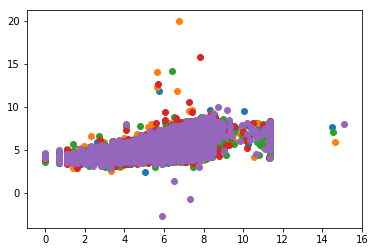

In [70]:
for train_index, test_index in cv.split(train):
    cTrainDe = train.loc[train_index][fList5+['trip_duration']]
    modelc = sm.OLS.from_formula(formulaIs5,cTrainDe)
    resultc = modelc.fit()
    x = '{}, {}, {}, {}, {}, {}'.format(resultc.aic,resultc.bic,resultc.llf, resultc.rsquared, resultc.rsquared_adj, resultc.condition_number)
    print (x)
    cTest = train.loc[test_index][fList5+['trip_duration']]
    yc_new = resultc.predict(cTest[fList5])
    yc_newis = np.exp(yc_new)
    rmsleIs = rmsle(cTest['trip_duration'],yc_newis)
    print (rmsleIs)
    yc = train.loc[test_index].apply(lambda x:np.log(x.trip_duration),axis=1)
    plt.scatter(yc,yc_new) 

752373.7712990284, 754419.1288186678, -376004.8856495142, 0.6421511006635915, 0.6420356943297951, 199676.52850767993
0.466297424681
748698.7516169837, 750744.1091366231, -374167.37580849184, 0.6435971105510163, 0.6434821705556664, 221722.55494306242
0.472565424388
749891.8105507002, 751937.1680703396, -374763.9052753501, 0.6445241544946314, 0.6444095134711183, 206531.98178361487
0.470645467175
751315.1667523261, 753360.524596142, -375475.58337616303, 0.6427637565358413, 0.6426485479889479, 208999.6058609257
0.46808136044
750839.2540269347, 752884.6118707507, -375237.62701346737, 0.6424824311885377, 0.6423671319143313, 220189.70087693044
0.468536379995


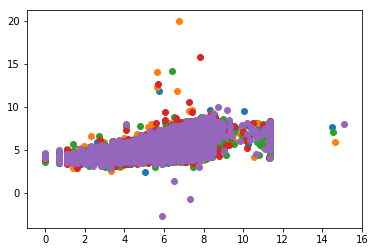

In [71]:
for train_index, test_index in cv.split(train):
    cTrainDe = train.loc[train_index][fList6+['trip_duration']]
    modelc = sm.OLS.from_formula(formulaIs6,cTrainDe)
    resultc = modelc.fit()
    x = '{}, {}, {}, {}, {}, {}'.format(resultc.aic,resultc.bic,resultc.llf, resultc.rsquared, resultc.rsquared_adj, resultc.condition_number)
    print (x)
    cTest = train.loc[test_index][fList6+['trip_duration']]
    yc_new = resultc.predict(cTest[fList6])
    yc_newis = np.exp(yc_new)
    rmsleIs = rmsle(cTest['trip_duration'],yc_newis)
    print (rmsleIs)
    yc = train.loc[test_index].apply(lambda x:np.log(x.trip_duration),axis=1)
    plt.scatter(yc,yc_new) 

756790.3199163208, 758813.2009797005, -378215.1599581604, 0.6393223326326531, 0.6392072997191172, 352.05944667521567
0.468770924876
754006.8879249941, 756029.7689883738, -376823.44396249705, 0.6402088464686975, 0.6400940962958983, 385.37092612520433
0.47348115816
754471.3305927173, 756494.211656097, -377055.66529635864, 0.6416101257785678, 0.6414958225234912, 351.16578011168747
0.472901630429
755975.2905120807, 757998.1718960744, -377807.6452560403, 0.6397835894209417, 0.6396687038232707, 348.5978502123627
0.470206340467
755717.8833683765, 757740.7647523703, -377678.94168418826, 0.6393595833980601, 0.6392445625700556, 359.341325025451
0.470645513165


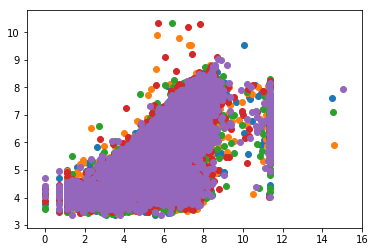

In [72]:
for train_index, test_index in cv.split(train):
    cTrainDe = train.loc[train_index][fList7+['trip_duration']]
    modelc = sm.OLS.from_formula(formulaIs7,cTrainDe)
    resultc = modelc.fit()
    x = '{}, {}, {}, {}, {}, {}'.format(resultc.aic,resultc.bic,resultc.llf, resultc.rsquared, resultc.rsquared_adj, resultc.condition_number)
    print (x)
    cTest = train.loc[test_index][fList7+['trip_duration']]
    yc_new = resultc.predict(cTest[fList7])
    yc_newis = np.exp(yc_new)
    rmsleIs = rmsle(cTest['trip_duration'],yc_newis)
    print (rmsleIs)
    yc = train.loc[test_index].apply(lambda x:np.log(x.trip_duration),axis=1)
    plt.scatter(yc,yc_new) 

756270.0473564956, 758528.931210603, -377934.0236782478, 0.6396833759049105, 0.6395549713640629, 1.654651905907655e+16
0.468601512482
753546.8666019174, 755783.2739997649, -376574.4333009587, 0.6405278653448134, 0.6404010432390521, 4.9100581832486616e+16
0.474026608463
753966.882886422, 756225.7667405293, -376782.441443211, 0.6419587869402748, 0.6418311932782201, 1.6634024489353056e+16
0.4727048647
755491.3162101076, 757738.962192323, -377545.6581050538, 0.6401196214191543, 0.6399920140414497, 4.885325024334915e+16
inf
755220.0929374689, 757478.9771495953, -377409.04646873445, 0.6397061610965658, 0.6395777649043626, 1.2728468505115396e+16
0.470445325351


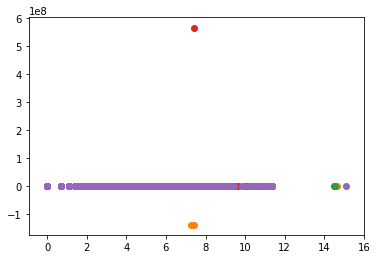

In [73]:
for train_index, test_index in cv.split(train):
    cTrainDe = train.loc[train_index][fList8+['trip_duration']]
    modelc = sm.OLS.from_formula(formulaIs8,cTrainDe)
    resultc = modelc.fit()
    x = '{}, {}, {}, {}, {}, {}'.format(resultc.aic,resultc.bic,resultc.llf, resultc.rsquared, resultc.rsquared_adj, resultc.condition_number)
    print (x)
    cTest = train.loc[test_index][fList8+['trip_duration']]
    yc_new = resultc.predict(cTest[fList8])
    yc_newis = np.exp(yc_new)
    rmsleIs = rmsle(cTest['trip_duration'],yc_newis)
    print (rmsleIs)
    yc = train.loc[test_index].apply(lambda x:np.log(x.trip_duration),axis=1)
    plt.scatter(yc,yc_new) 

#### 종속변수에 대한 독립변수의 영향도를 F 검정을 사용하여 비교

In [74]:
sm.stats.anova_lm(result1,typ =2)

,sum_sq,df,F,PR(>F)
C(pickup_dropoff_same_Province),6.942547,1.0,29.722949,4.985802e-08
C(pickup_Province),2613.432733,5.0,2237.764587,0.000000e+00
C(dropoff_Province),729.151972,5.0,624.339950,0.000000e+00
C(hr):C(day_of_week),20379.727392,167.0,522.462319,0.000000e+00
I(np.log(distance + 1)),171829.379332,1.0,735648.741158,0.000000e+00
hour_day_of_week_float,624.132103,1.0,2672.080862,0.000000e+00
dropoff_longitude,712.234025,1.0,3049.269373,0.000000e+00
dropoff_latitude,609.135034,1.0,2607.874291,0.000000e+00
Residual,163875.499919,701596.0,NaN,NaN


In [75]:
sm.stats.anova_lm(result2,typ =2)

,sum_sq,df,F,PR(>F)
C(pickup_dropoff_same_Province),6.942547,1.0,29.722949,4.985802e-08
C(pickup_Province),2613.432733,5.0,2237.764587,0.000000e+00
C(dropoff_Province),729.151972,5.0,624.339950,0.000000e+00
C(hr):C(day_of_week),20379.727389,167.0,522.462319,0.000000e+00
I(np.log(distance + 1)),171829.379332,1.0,735648.741158,0.000000e+00
dropoff_longitude,712.234025,1.0,3049.269373,0.000000e+00
dropoff_latitude,609.135034,1.0,2607.874291,0.000000e+00
Residual,163875.499919,701596.0,NaN,NaN


In [76]:
sm.stats.anova_lm(result3,typ =2)

,sum_sq,df,F,PR(>F)
C(pickup_dropoff_same_Province),1.635001,1.0,6.938084,0.008438
C(pickup_Province),2644.343380,5.0,2244.239804,0.000000
C(dropoff_Province),1363.706797,5.0,1157.370520,0.000000
C(hr):C(day_of_week),20427.184271,167.0,519.055086,0.000000
I(np.log(distance + 1)),171191.725452,1.0,726447.418360,0.000000
Residual,165335.809803,701598.0,NaN,NaN


In [77]:
sm.stats.anova_lm(result4,typ =2)

,sum_sq,df,F,PR(>F)
C(pickup_dropoff_same_Province),0.064181,1.0,0.272809,0.601454
C(dropoff_Province):C(pickup_Province),1381.016204,35.0,167.718441,0.000000
C(hr):C(day_of_week),20516.905849,167.0,522.210358,0.000000
I(np.log(distance + 1)),170357.656880,1.0,724122.004999,0.000000
Residual,165053.696775,701577.0,NaN,NaN


In [78]:
sm.stats.anova_lm(result5,typ =2)

,sum_sq,df,F,PR(>F)
C(pickup_dropoff_same_Province),172.308415,1.0,773.109427,4.691881e-170
C(pickup_Province),793.065411,5.0,711.661521,0.000000e+00
C(dropoff_Province),209.071458,5.0,187.611399,2.104976e-200
C(hr):C(day_of_week),20048.648770,167.0,538.645600,0.000000e+00
I(np.log(distance + 0.1)),179335.171584,1.0,804636.914147,0.000000e+00
hour_day_of_week_float,603.310626,1.0,2706.920212,0.000000e+00
dropoff_longitude,375.800019,1.0,1686.130862,0.000000e+00
dropoff_latitude,832.949672,1.0,3737.259389,0.000000e+00
Residual,156369.707666,701596.0,NaN,NaN


In [79]:
sm.stats.anova_lm(result6,typ =2)

,sum_sq,df,F,PR(>F)
C(pickup_dropoff_same_Province),172.308415,1.0,773.109427,4.691881e-170
C(pickup_Province),793.065411,5.0,711.661521,0.000000e+00
C(dropoff_Province),209.071458,5.0,187.611399,2.104976e-200
C(hr):C(day_of_week),20048.648771,167.0,538.645600,0.000000e+00
I(np.log(distance + 0.1)),179335.171584,1.0,804636.914147,0.000000e+00
dropoff_longitude,375.800019,1.0,1686.130862,0.000000e+00
dropoff_latitude,832.949672,1.0,3737.259389,0.000000e+00
Residual,156369.707666,701596.0,NaN,NaN


In [80]:
sm.stats.anova_lm(result7,typ =2)

,sum_sq,df,F,PR(>F)
C(pickup_dropoff_same_Province),198.517491,1.0,883.212982,5.781536e-194
C(pickup_Province),801.092234,5.0,712.818863,0.000000e+00
C(dropoff_Province),521.583446,5.0,464.109503,0.000000e+00
C(hr):C(day_of_week),20120.383833,167.0,536.026742,0.000000e+00
I(np.log(distance + 0.1)),178831.172668,1.0,795627.692504,0.000000e+00
Residual,157696.362587,701598.0,NaN,NaN


In [81]:
sm.stats.anova_lm(result8,typ =2)

,sum_sq,df,F,PR(>F)
C(pickup_dropoff_same_Province),0.041434,1.0,0.184511,0.667525
C(dropoff_Province):C(pickup_Province),602.410901,35.0,76.645948,0.000000
C(hr):C(day_of_week),20161.380058,167.0,537.611074,0.000000
I(np.log(distance + 0.1)),177864.075676,1.0,792050.113813,0.000000
Residual,157547.284502,701577.0,NaN,NaN


#### 잔차의 정규성을 확인

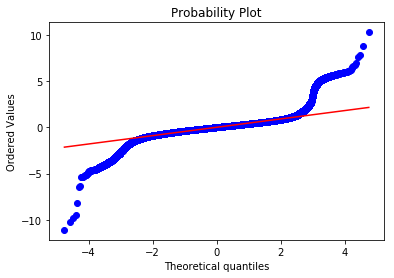

In [82]:
sp.stats.probplot(result1.resid, plot=plt)
plt.show()

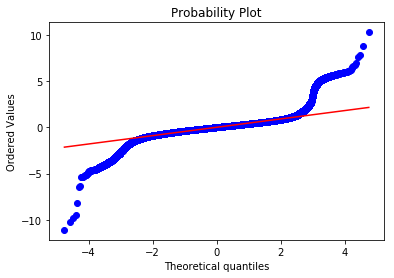

In [83]:
sp.stats.probplot(result2.resid, plot=plt)
plt.show()

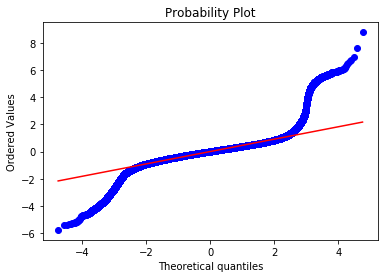

In [84]:
sp.stats.probplot(result3.resid, plot=plt)
plt.show()

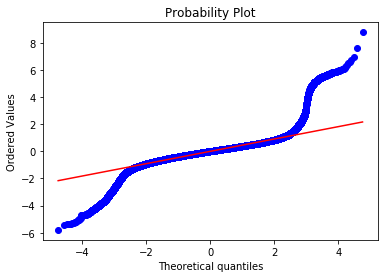

In [85]:
sp.stats.probplot(result4.resid, plot=plt)
plt.show()

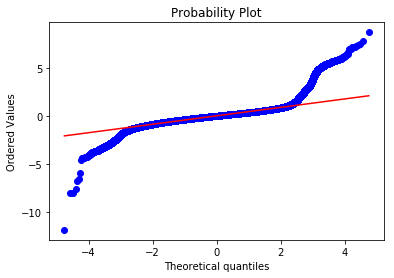

In [86]:
sp.stats.probplot(result5.resid, plot=plt)
plt.show()

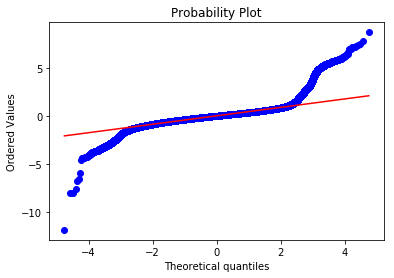

In [87]:
sp.stats.probplot(result6.resid, plot=plt)
plt.show()

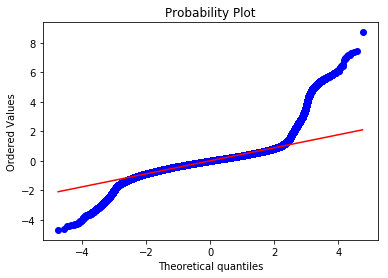

In [88]:
sp.stats.probplot(result7.resid, plot=plt)
plt.show()

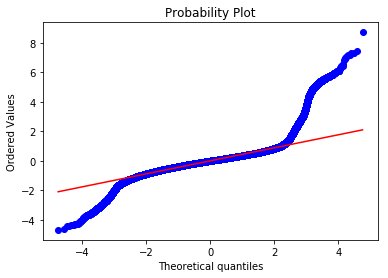

In [89]:
sp.stats.probplot(result8.resid, plot=plt)
plt.show()

* 정규성 검정을 통해 확인

In [90]:
test = sms.omni_normtest(result1.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print ("%-10s: %6.3f " % xi)
test = sms.jarque_bera(result1.resid)
for xi in zip(['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis'], test):
    print("%-12s: %6.3f" % xi)

Chi^2     : 241722.749 
P-value   :  0.000 
Jarque-Bera : 14672166.748
P-value     :  0.000
Skew        :  0.843
Kurtosis    : 25.337


In [91]:
test = sms.omni_normtest(result2.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print ("%-10s: %6.3f " % xi)
test = sms.jarque_bera(result2.resid)
for xi in zip(['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis'], test):
    print("%-12s: %6.3f" % xi)

Chi^2     : 241722.749 
P-value   :  0.000 
Jarque-Bera : 14672166.748
P-value     :  0.000
Skew        :  0.843
Kurtosis    : 25.337


In [92]:
test = sms.omni_normtest(result3.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print ("%-10s: %6.3f " % xi)
test = sms.jarque_bera(result3.resid)
for xi in zip(['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis'], test):
    print("%-12s: %6.3f" % xi)

Chi^2     : 236806.797 
P-value   :  0.000 
Jarque-Bera : 12069339.980
P-value     :  0.000
Skew        :  0.860
Kurtosis    : 23.244


In [93]:
test = sms.omni_normtest(result4.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print ("%-10s: %6.3f " % xi)
test = sms.jarque_bera(result4.resid)
for xi in zip(['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis'], test):
    print("%-12s: %6.3f" % xi)

Chi^2     : 237094.134 
P-value   :  0.000 
Jarque-Bera : 12177071.513
P-value     :  0.000
Skew        :  0.859
Kurtosis    : 23.334


In [94]:
test = sms.omni_normtest(result5.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print ("%-10s: %6.3f " % xi)
test = sms.jarque_bera(result5.resid)
for xi in zip(['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis'], test):
    print("%-12s: %6.3f" % xi)

Chi^2     : 361684.772 
P-value   :  0.000 
Jarque-Bera : 16020315.470
P-value     :  0.000
Skew        :  1.787
Kurtosis    : 26.132


In [95]:
test = sms.omni_normtest(result6.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print ("%-10s: %6.3f " % xi)
test = sms.jarque_bera(result6.resid)
for xi in zip(['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis'], test):
    print("%-12s: %6.3f" % xi)

Chi^2     : 361684.772 
P-value   :  0.000 
Jarque-Bera : 16020315.470
P-value     :  0.000
Skew        :  1.787
Kurtosis    : 26.132


In [96]:
test = sms.omni_normtest(result7.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print ("%-10s: %6.3f " % xi)
test = sms.jarque_bera(result5.resid)
for xi in zip(['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis'], test):
    print("%-12s: %6.3f" % xi)

Chi^2     : 356793.383 
P-value   :  0.000 
Jarque-Bera : 16020315.470
P-value     :  0.000
Skew        :  1.787
Kurtosis    : 26.132


In [97]:
test = sms.omni_normtest(result8.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print ("%-10s: %6.3f " % xi)
test = sms.jarque_bera(result6.resid)
for xi in zip(['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis'], test):
    print("%-12s: %6.3f" % xi)

Chi^2     : 356702.435 
P-value   :  0.000 
Jarque-Bera : 16020315.470
P-value     :  0.000
Skew        :  1.787
Kurtosis    : 26.132


#### 잔차와 독립변수의 관계 확인
* 이분산성

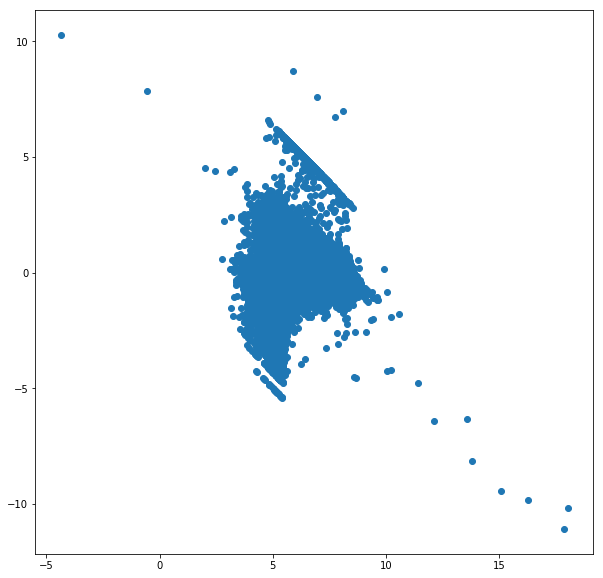

In [98]:
fig = plt.figure(figsize=(10,10))
plt.scatter(result1.predict(),result1.resid)
plt.show()

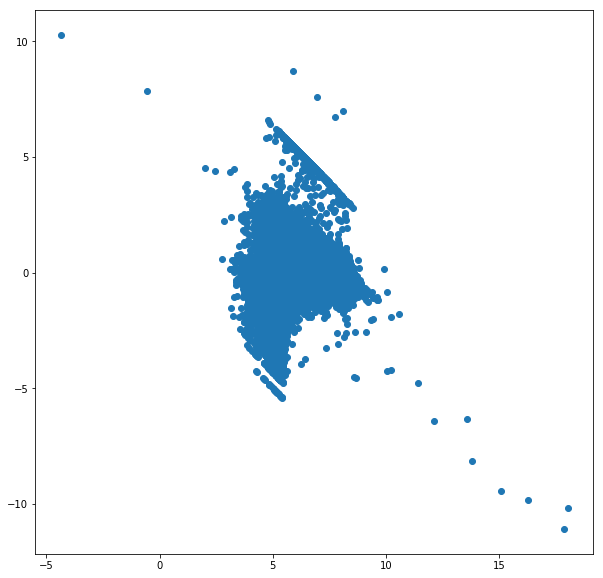

In [99]:
fig = plt.figure(figsize=(10,10))
plt.scatter(result2.predict(),result2.resid)
plt.show()

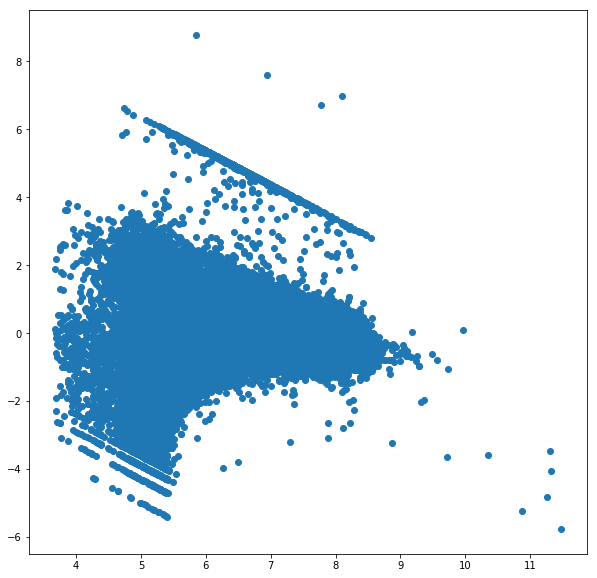

In [100]:
fig = plt.figure(figsize=(10,10))
plt.scatter(result3.predict(),result3.resid)
plt.show()

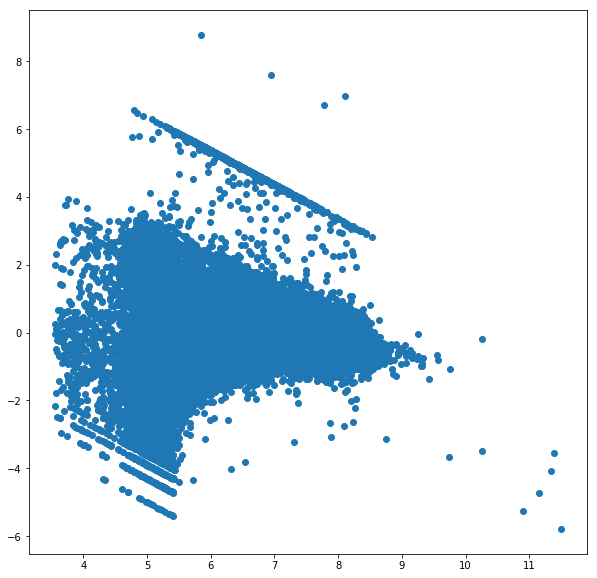

In [101]:
fig = plt.figure(figsize=(10,10))
plt.scatter(result4.predict(),result4.resid)
plt.show()

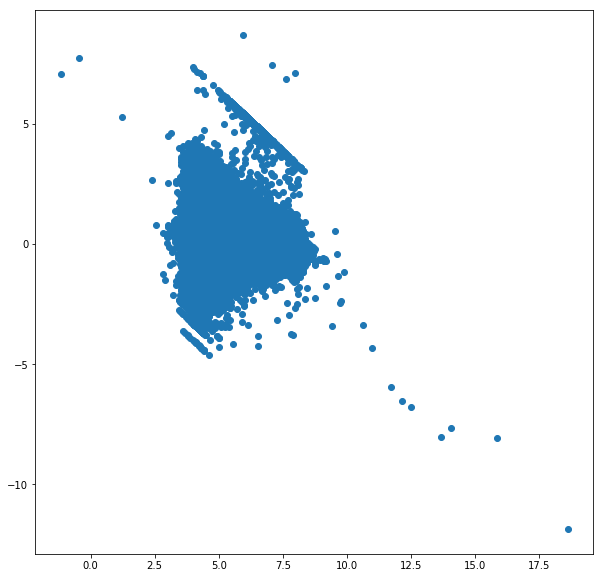

In [102]:
fig = plt.figure(figsize=(10,10))
plt.scatter(result5.predict(),result5.resid)
plt.show()

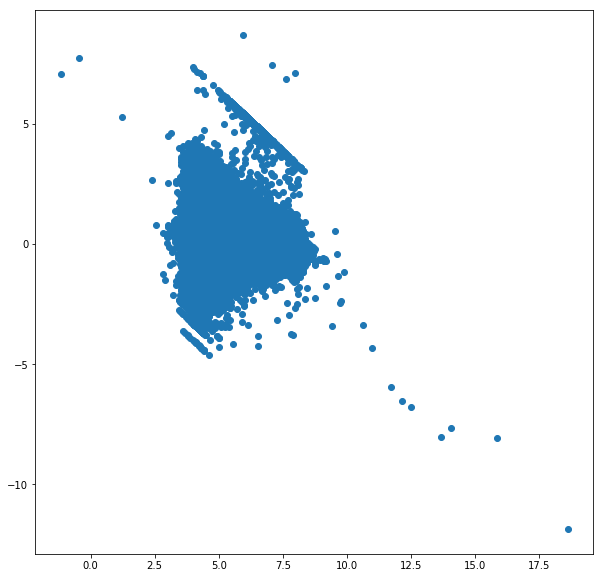

In [103]:
fig = plt.figure(figsize=(10,10))
plt.scatter(result6.predict(),result6.resid)
plt.show()

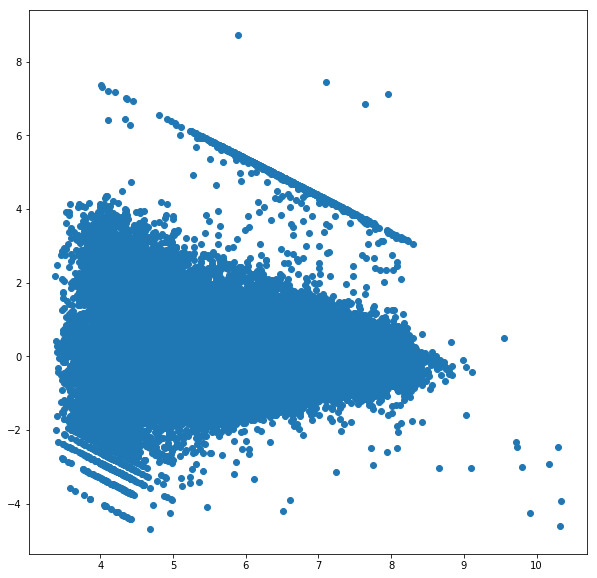

In [104]:
fig = plt.figure(figsize=(10,10))
plt.scatter(result7.predict(),result7.resid)
plt.show()

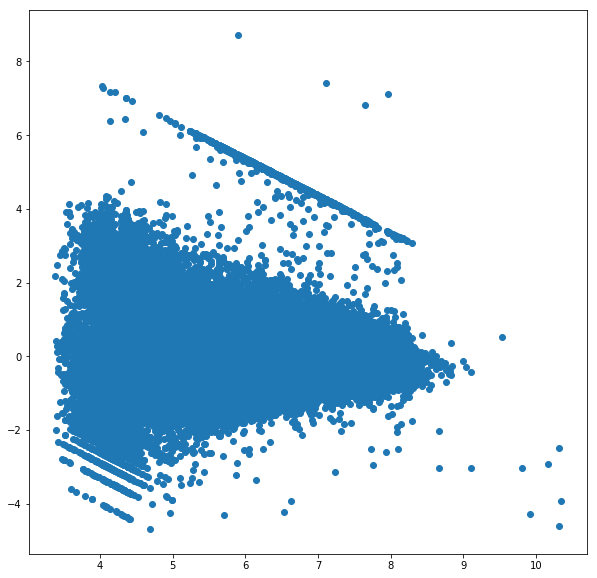

In [105]:
fig = plt.figure(figsize=(10,10))
plt.scatter(result8.predict(),result8.resid)
plt.show()

* 종속변수를 log-transform을 하였는데 이분산성이 나타나는 것을 확인함.

#### 자기 상관 계수 확인
* 오차가 독립인지를 검정

In [106]:
print (stools.durbin_watson(result1.resid))

1.95406948017


In [107]:
print (stools.durbin_watson(result2.resid))

1.95406948017


In [108]:
print (stools.durbin_watson(result3.resid))

1.95477579228


In [109]:
print (stools.durbin_watson(result4.resid))

1.95465256988


In [110]:
print (stools.durbin_watson(result5.resid))

1.95249598383


In [111]:
print (stools.durbin_watson(result6.resid))

1.95249598383


In [112]:
print (stools.durbin_watson(result7.resid))

1.95334205909


In [113]:
print (stools.durbin_watson(result8.resid))

1.9532180243


##### Root Mean Squared Logarithmic Error (RMSLE)

In [115]:
y_newis1 = np.exp(y_new)
rmsle(train['trip_duration'],y_newis1)

0.47959324750974786

In [116]:
y_newis2 = np.exp(y_new2)
rmsle(train['trip_duration'],y_newis2)

0.47959324750975052

In [117]:
y_newis3 = np.exp(y_new3)
rmsle(train['trip_duration'],y_newis3)

0.48187034276335433

In [118]:
y_newis4 = np.exp(y_new4)
rmsle(train['trip_duration'],y_newis4)

0.48145250609760193

In [119]:
y_newis5 = np.exp(y_new5)
rmsle(train['trip_duration'],y_newis5)

0.4689964467387347

In [120]:
y_newis6 = np.exp(y_new6)
rmsle(train['trip_duration'],y_newis6)

0.46899644673873925

In [121]:
y_newis7 = np.exp(y_new7)
rmsle(train['trip_duration'],y_newis7)

0.47104843212475711

In [122]:
y_newis8 = np.exp(y_new8)
rmsle(train['trip_duration'],y_newis8)

0.47082030455212887

#### Leverage & Outlier

In [123]:
def Get_Outlier(train, fList, result):
    inf = result.get_influence()
    hat = inf.hat_matrix_diag
    print('hat.sum() =',hat.sum())
    x_new = train[fList]
    y_new = result.predict()
    cooks_d2, pvals = inf.cooks_distance
    fox_cr = 4 / (len(train['trip_duration']) - 182)
    idx = np.where(cooks_d2 > fox_cr)[0]
    ax = plt.subplot()
    plt.scatter(y_new,train['trip_duration'])
    plt.scatter(y_new[idx], train['trip_duration'][idx], s=300, c="r", alpha=0.5)
    utils.annotate_axes(range(len(idx)), idx, 
                        list(zip(y_new[idx], train['trip_duration'][idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
    plt.show()
    print (len(idx))
    return idx

* Fox recommentation 기준 Outlier 선정

hat.sum() = 182.0


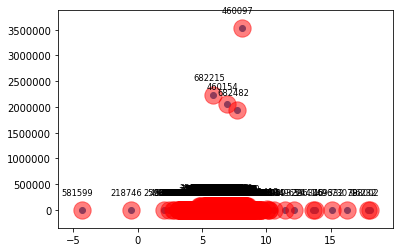

22513
(679265, 33)


In [124]:
outlier1 = Get_Outlier(train, fList1, result1)
filter_x_1 = train.drop(outlier1, 0)
print (filter_x_1.shape)


hat.sum() = 182.0


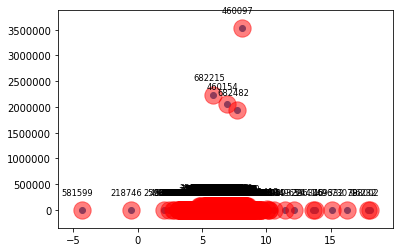

22669
(679109, 33)


In [125]:
outlier2 = Get_Outlier(train, fList2, result2)
filter_x_2 = train.drop(outlier2, 0)
print (filter_x_2.shape)


hat.sum() = 180.0


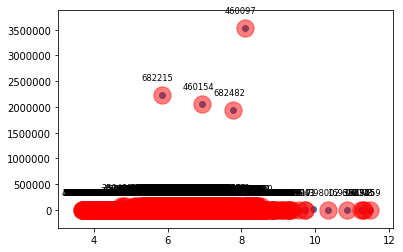

22859
(678919, 33)


In [126]:
outlier3 = Get_Outlier(train, fList3, result3)
filter_x_3 = train.drop(outlier3, 0)
print (filter_x_3.shape)


hat.sum() = 199.999999967


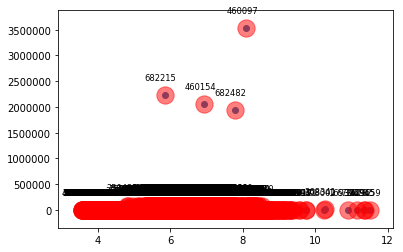

20039
(681739, 33)


In [127]:
outlier4 = Get_Outlier(train, fList4, result4)
filter_x_4 = train.drop(outlier4, 0)
print (filter_x_4.shape)


hat.sum() = 182.0


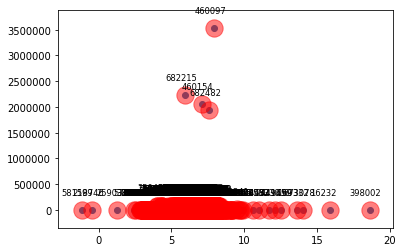

21776
(680002, 33)


In [128]:
outlier5 = Get_Outlier(train, fList5, result5)
filter_x_5 = train.drop(outlier5, 0)
print (filter_x_5.shape)


hat.sum() = 182.0


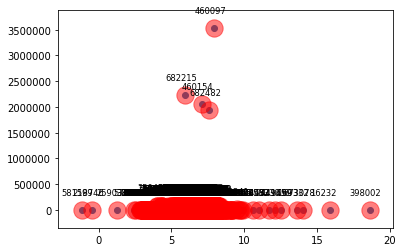

21902
(679876, 33)


In [129]:
outlier6 = Get_Outlier(train, fList6, result6)
filter_x_6 = train.drop(outlier6, 0)
print (filter_x_6.shape)


hat.sum() = 180.0


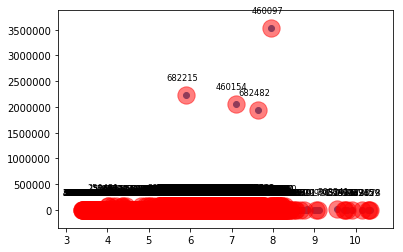

22120
(679658, 33)


In [130]:
outlier7 = Get_Outlier(train, fList7, result7)
filter_x_7 = train.drop(outlier7, 0)
print (filter_x_7.shape)


hat.sum() = 200.000000007


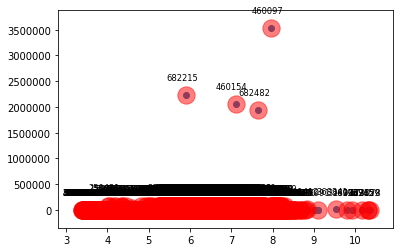

19369
(682409, 33)


In [131]:
outlier8 = Get_Outlier(train, fList8, result8)
filter_x_8 = train.drop(outlier8, 0)
print (filter_x_8.shape)


#### 실제값과 회귀모델 식으로 구한 값사이의 연관성을 확인

In [141]:
def ReModeling(formulaIs, fList, data):
    model = sm.OLS.from_formula(formulaIs, data = data)
    result = model.fit()
    y_newa = result.predict(data[fList])
    ya = data.apply(lambda x:np.log(x.trip_duration),axis=1)
    plt.scatter(ya,y_newa)
    plt.show()
    return result, y_newa

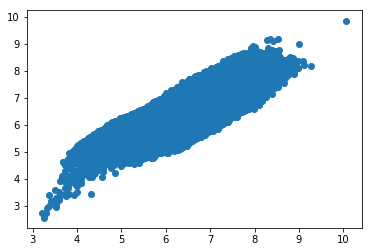

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.725
Model:                                  OLS   Adj. R-squared:                  0.725
Method:                       Least Squares   F-statistic:                     9911.
Date:                      Wed, 28 Mar 2018   Prob (F-statistic):               0.00
Time:                              22:53:27   Log-Likelihood:            -2.8260e+05
No. Observations:                    679265   AIC:                         5.656e+05
Df Residuals:                        679083   BIC:                         5.676e+05
Df Model:                               181                                         
Covariance Type:                  nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             -100.1913      1.940    -51.643      0.000    -103.994     -96.389
C(pickup_dropoff_same_Province)[T.1]     0.0260      0.002     10.935      0.000       0.021       0.031
C(pickup_Province)[T.Brooklyn]          -0.1939      0.022     -8.794      0.000      -0.237      -0.151
C(pickup_Province)[T.Manhattan]         -0.1229      0.022     -5.653      0.000      -0.166      -0.080
C(pickup_Province)[T.Queens]            -0.3964      0.022    -18.131      0.000      -0.439      -0.354
C(pickup_Province)[T.Staten Island]      1.0615      0.264      4.028      0.000       0.545       1.578
C(pickup_Province)[T.outward]           -0.6491      0.040    -16.229      0.000      -0.727      -0.571
C(dropoff_Province)[T.Brooklyn]          0.0766      0.007     11.275      0.000       0.063       0.090
C(dropoff_Province)[T.Manhattan]         0.0580      0.006      8.953      0.000       0.045       0.071
C(dropoff_Province)[T.Queens]            0.1253      0.007     18.850      0.000       0.112       0.138
C(dropoff_Province)[T.Staten Island]    -0.7198      0.041    -17.457      0.000      -0.801      -0.639
C(dropoff_Province)[T.outward]          -0.5097      0.011    -47.976      0.000      -0.531      -0.489
C(day_of_week)[T.1]                     -0.0813      0.011     -7.188      0.000      -0.103      -0.059
C(day_of_week)[T.2]                     -0.2040      0.010    -20.140      0.000      -0.224      -0.184
C(day_of_week)[T.3]                     -0.3331      0.009    -35.901      0.000      -0.351      -0.315
C(day_of_week)[T.4]                     -0.4111      0.008    -51.228      0.000      -0.427      -0.395
C(day_of_week)[T.5]                     -0.4481      0.008    -57.262      0.000      -0.463      -0.433
C(day_of_week)[T.6]                     -0.5941      0.009    -65.590      0.000      -0.612      -0.576
C(hr)[T.1]:C(day_of_week)[0]            -0.0152      0.014     -1.062      0.288      -0.043       0.013
C(hr)[T.2]:C(day_of_week)[0]            -0.0114      0.018     -0.631      0.528      -0.047       0.024
C(hr)[T.3]:C(day_of_week)[0]            -0.0192      0.021     -0.904      0.366      -0.061       0.022
C(hr)[T.4]:C(day_of_week)[0]            -0.1057      0.020     -5.415      0.000      -0.144      -0.067
C(hr)[T.5]:C(day_of_week)[0]            -0.1228      0.015     -8.097      0.000      -0.153      -0.093
C(hr)[T.6]:C(day_of_week)[0]            -0.0134      0.011     -1.223      0.221      -0.035       0.008
C(hr)[T.7]:C(day_of_week)[0]             0.2203      0.010     22.424      0.000       0.201       0.240
C(hr)[T.8]:C(day_of_week)[0]             0.4009      0.009     42.438      0.

In [143]:
reR1, y_newa1 = ReModeling(formulaIs1, fList1, filter_x_1)
reR1.summary()

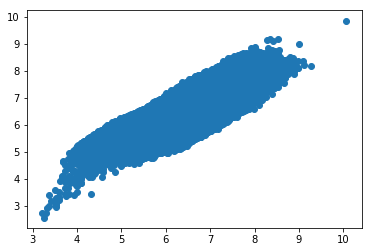

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.726
Model:                                  OLS   Adj. R-squared:                  0.726
Method:                       Least Squares   F-statistic:                     9919.
Date:                      Wed, 28 Mar 2018   Prob (F-statistic):               0.00
Time:                              22:54:50   Log-Likelihood:            -2.8209e+05
No. Observations:                    679109   AIC:                         5.646e+05
Df Residuals:                        678927   BIC:                         5.666e+05
Df Model:                               181                                         
Covariance Type:                  nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                             -100.1034      1.939    -51.623      0.000    -103.904     -96.303
C(pickup_dropoff_same_Province)[T.1]     0.0260      0.002     10.945      0.000       0.021       0.031
C(pickup_Province)[T.Brooklyn]          -0.1940      0.022     -8.802      0.000      -0.237      -0.151
C(pickup_Province)[T.Manhattan]         -0.1227      0.022     -5.648      0.000      -0.165      -0.080
C(pickup_Province)[T.Queens]            -0.3962      0.022    -18.133      0.000      -0.439      -0.353
C(pickup_Province)[T.Staten Island]      1.0616      0.263      4.031      0.000       0.545       1.578
C(pickup_Province)[T.outward]           -0.6499      0.040    -16.258      0.000      -0.728      -0.572
C(dropoff_Province)[T.Brooklyn]          0.0763      0.007     11.222      0.000       0.063       0.090
C(dropoff_Province)[T.Manhattan]         0.0577      0.006      8.911      0.000       0.045       0.070
C(dropoff_Province)[T.Queens]            0.1249      0.007     18.794      0.000       0.112       0.138
C(dropoff_Province)[T.Staten Island]    -0.7201      0.041    -17.476      0.000      -0.801      -0.639
C(dropoff_Province)[T.outward]          -0.5089      0.011    -47.891      0.000      -0.530      -0.488
C(day_of_week)[T.1]                      0.0648      0.012      5.386      0.000       0.041       0.088
C(day_of_week)[T.2]                      0.0876      0.012      7.615      0.000       0.065       0.110
C(day_of_week)[T.3]                      0.1043      0.011      9.422      0.000       0.083       0.126
C(day_of_week)[T.4]                      0.1725      0.010     16.866      0.000       0.152       0.193
C(day_of_week)[T.5]                      0.2810      0.010     28.884      0.000       0.262       0.300
C(day_of_week)[T.6]                      0.2805      0.010     28.718      0.000       0.261       0.300
C(hr)[T.1]:C(day_of_week)[0]            -0.0086      0.014     -0.596      0.551      -0.037       0.020
C(hr)[T.2]:C(day_of_week)[0]            -0.0007      0.018     -0.037      0.971      -0.036       0.035
C(hr)[T.3]:C(day_of_week)[0]            -0.0010      0.021     -0.045      0.964      -0.043       0.041
C(hr)[T.4]:C(day_of_week)[0]            -0.0796      0.020     -4.042      0.000      -0.118      -0.041
C(hr)[T.5]:C(day_of_week)[0]            -0.0924      0.015     -6.011      0.000      -0.123      -0.062
C(hr)[T.6]:C(day_of_week)[0]             0.0230      0.011      2.031      0.042       0.001       0.045
C(hr)[T.7]:C(day_of_week)[0]             0.2630      0.010     25.606      0.000       0.243       0.283
C(hr)[T.8]:C(day_of_week)[0]             0.4495      0.010     45.061      0.

In [144]:
reR2, y_newa2 = ReModeling(formulaIs2, fList2, filter_x_2)
reR2.summary()

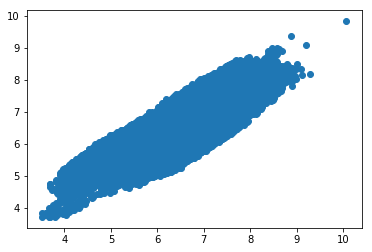

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.718
Model:                                  OLS   Adj. R-squared:                  0.718
Method:                       Least Squares   F-statistic:                     9669.
Date:                      Wed, 28 Mar 2018   Prob (F-statistic):               0.00
Time:                              22:56:13   Log-Likelihood:            -2.9058e+05
No. Observations:                    678919   AIC:                         5.815e+05
Df Residuals:                        678739   BIC:                         5.836e+05
Df Model:                               179                                         
Covariance Type:                  nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                4.5758      0.024    192.741      0.000       4.529       4.622
C(pickup_dropoff_same_Province)[T.1]     0.0078      0.002      3.250      0.001       0.003       0.013
C(pickup_Province)[T.Brooklyn]          -0.1326      0.023     -5.892      0.000      -0.177      -0.088
C(pickup_Province)[T.Manhattan]         -0.0679      0.022     -3.059      0.002      -0.111      -0.024
C(pickup_Province)[T.Queens]            -0.3404      0.022    -15.251      0.000      -0.384      -0.297
C(pickup_Province)[T.Staten Island]      1.0228      0.267      3.838      0.000       0.500       1.545
C(pickup_Province)[T.outward]           -0.6715      0.040    -16.706      0.000      -0.750      -0.593
C(dropoff_Province)[T.Brooklyn]          0.3707      0.006     58.347      0.000       0.358       0.383
C(dropoff_Province)[T.Manhattan]         0.3172      0.006     50.284      0.000       0.305       0.330
C(dropoff_Province)[T.Queens]            0.1883      0.006     29.615      0.000       0.176       0.201
C(dropoff_Province)[T.Staten Island]    -0.0525      0.040     -1.305      0.192      -0.131       0.026
C(dropoff_Province)[T.outward]          -0.1128      0.010    -11.190      0.000      -0.133      -0.093
C(day_of_week)[T.1]                      0.0597      0.012      4.896      0.000       0.036       0.084
C(day_of_week)[T.2]                      0.0857      0.012      7.351      0.000       0.063       0.108
C(day_of_week)[T.3]                      0.1023      0.011      9.119      0.000       0.080       0.124
C(day_of_week)[T.4]                      0.1725      0.010     16.656      0.000       0.152       0.193
C(day_of_week)[T.5]                      0.2836      0.010     28.797      0.000       0.264       0.303
C(day_of_week)[T.6]                      0.2847      0.010     28.787      0.000       0.265       0.304
C(hr)[T.1]:C(day_of_week)[0]            -0.0103      0.015     -0.707      0.480      -0.039       0.018
C(hr)[T.2]:C(day_of_week)[0]            -0.0037      0.018     -0.201      0.840      -0.040       0.032
C(hr)[T.3]:C(day_of_week)[0]             0.0015      0.022      0.068      0.946      -0.041       0.044
C(hr)[T.4]:C(day_of_week)[0]            -0.0921      0.020     -4.568      0.000      -0.132      -0.053
C(hr)[T.5]:C(day_of_week)[0]            -0.1021      0.016     -6.550      0.000      -0.133      -0.072
C(hr)[T.6]:C(day_of_week)[0]             0.0175      0.011      1.528      0.127      -0.005       0.040
C(hr)[T.7]:C(day_of_week)[0]             0.2573      0.010     24.752      0.000       0.237       0.278
C(hr)[T.8]:C(day_of_week)[0]             0.4486      0.010     44.421      0.

In [145]:
reR3, y_newa3 = ReModeling(formulaIs3, fList3, filter_x_3)
reR3.summary()

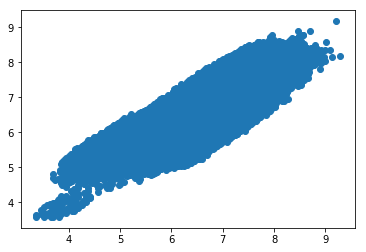

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.714
Model:                                  OLS   Adj. R-squared:                  0.714
Method:                       Least Squares   F-statistic:                     8710.
Date:                      Wed, 28 Mar 2018   Prob (F-statistic):               0.00
Time:                              22:57:41   Log-Likelihood:            -3.0148e+05
No. Observations:                    681739   AIC:                         6.034e+05
Df Residuals:                        681543   BIC:                         6.056e+05
Df Model:                               195                                         
Covariance Type:                  nonrobust                                         
==========================================================================================================================================
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                               3.841e+08   4.38e+08      0.878      0.380   -4.74e+08    1.24e+09
C(pickup_dropoff_same_Province)[T.1]                                   -3.841e+08   4.38e+08     -0.878      0.380   -1.24e+09    4.74e+08
C(pickup_Province)[T.Brooklyn]                                         -3.841e+08   4.38e+08     -0.878      0.380   -1.24e+09    4.74e+08
C(pickup_Province)[T.Manhattan]                                        -3.841e+08   4.38e+08     -0.878      0.380   -1.24e+09    4.74e+08
C(pickup_Province)[T.Queens]                                           -3.841e+08   4.38e+08     -0.878      0.380   -1.24e+09    4.74e+08
C(pickup_Province)[T.Staten Island]                                    -2.808e+04    3.2e+04     -0.878      0.380   -9.08e+04    3.46e+04
C(pickup_Province)[T.outward]                                          -3.841e+08   4.38e+08     -0.878      0.380   -1.24e+09    4.74e+08
C(dropoff_Province)[T.Brooklyn]:C(pickup_Province)[Bronx]               3.974e+04   4.53e+04      0.878      0.380    -4.9e+04    1.28e+05
C(dropoff_Province)[T.Manhattan]:C(pickup_Province)[Bronx]             -3.841e+08   4.38e+08     -0.878      0.380   -1.24e+09    4.74e+08
C(dropoff_Province)[T.Queens]:C(pickup_Province)[Bronx]                -3.841e+08   4.38e+08     -0.878      0.380   -1.24e+09    4.74e+08
C(dropoff_Province)[T.Staten Island]:C(pickup_Province)[Bronx]          7.119e+04   8.11e+04      0.878      0.380   -8.78e+04     2.3e+05
C(dropoff_Province)[T.outward]:C(pickup_Province)[Bronx]               -3.841e+08   4.38e+08     -0.878      0.380   -1.24e+09    4.74e+08
C(dropoff_Province)[T.Brooklyn]:C(pickup_Province)[Brooklyn]            3.841e+08   4.38e+08      0.878      0.380   -4.74e+08    1.24e+09
C(dropoff_Province)[T.Manhattan]:C(pickup_Province)[Brooklyn]              0.4657      0.154      3.025      0.002       0.164       0.767
C(dropoff_Province)[T.Queens]:C(pickup_Province)[Brooklyn]                 0.2436      0.155      1.575      0.115      -0.059       0.547
C(dropoff_Province)[T.Staten Island]:C(pickup_Province)[Brooklyn]      -9249.7958   1.05e+04     -0.878      0.380   -2.99e+04    1.14e+04
C(dropoff_Province)[T.outward]:C(pickup_Province)[Brooklyn]                0.0716      0.217      0.329      0.742      -0.355       0.498
C(dropoff_Province)[T.Brooklyn]:C(pickup_Province)[Manhattan]              0.4365      0.007     61.263      0.000       0.423       0.450
C(dropoff_Province)[T.Manhattan]:C(pickup_Province)[Manhattan]          3.841e+08   4.38e+08      

In [146]:
reR4, y_newa4 = ReModeling(formulaIs4, fList4, filter_x_4)
reR4.summary()

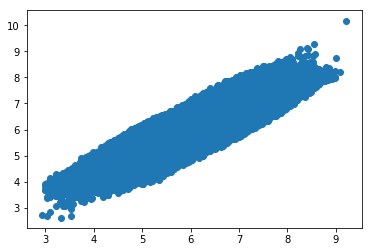

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.751
Model:                                  OLS   Adj. R-squared:                  0.751
Method:                       Least Squares   F-statistic:                 1.137e+04
Date:                      Wed, 28 Mar 2018   Prob (F-statistic):               0.00
Time:                              22:59:00   Log-Likelihood:            -2.5788e+05
No. Observations:                    680002   AIC:                         5.161e+05
Df Residuals:                        679821   BIC:                         5.182e+05
Df Model:                               180                                         
Covariance Type:                  nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                              -45.1776      1.815    -24.885      0.000     -48.736     -41.619
C(pickup_dropoff_same_Province)[T.1]    -0.0529      0.002    -23.674      0.000      -0.057      -0.049
C(pickup_Province)[T.Brooklyn]          -0.2320      0.021    -10.820      0.000      -0.274      -0.190
C(pickup_Province)[T.Manhattan]         -0.1642      0.021     -7.764      0.000      -0.206      -0.123
C(pickup_Province)[T.Queens]            -0.3464      0.021    -16.284      0.000      -0.388      -0.305
C(pickup_Province)[T.outward]           -0.1764      0.034     -5.156      0.000      -0.244      -0.109
C(dropoff_Province)[T.Brooklyn]         -0.0155      0.006     -2.396      0.017      -0.028      -0.003
C(dropoff_Province)[T.Manhattan]         0.0171      0.006      2.765      0.006       0.005       0.029
C(dropoff_Province)[T.Queens]            0.0436      0.006      6.885      0.000       0.031       0.056
C(dropoff_Province)[T.Staten Island]    -0.5697      0.040    -14.165      0.000      -0.648      -0.491
C(dropoff_Province)[T.outward]          -0.3524      0.010    -35.806      0.000      -0.372      -0.333
C(day_of_week)[T.1]                     -0.0903      0.011     -8.326      0.000      -0.112      -0.069
C(day_of_week)[T.2]                     -0.2059      0.010    -21.139      0.000      -0.225      -0.187
C(day_of_week)[T.3]                     -0.3324      0.009    -37.251      0.000      -0.350      -0.315
C(day_of_week)[T.4]                     -0.4072      0.008    -52.720      0.000      -0.422      -0.392
C(day_of_week)[T.5]                     -0.4485      0.008    -59.567      0.000      -0.463      -0.434
C(day_of_week)[T.6]                     -0.5922      0.009    -68.000      0.000      -0.609      -0.575
C(hr)[T.1]:C(day_of_week)[0]            -0.0246      0.014     -1.796      0.073      -0.051       0.002
C(hr)[T.2]:C(day_of_week)[0]            -0.0120      0.017     -0.695      0.487      -0.046       0.022
C(hr)[T.3]:C(day_of_week)[0]            -0.0081      0.020     -0.403      0.687      -0.047       0.031
C(hr)[T.4]:C(day_of_week)[0]            -0.1007      0.018     -5.499      0.000      -0.137      -0.065
C(hr)[T.5]:C(day_of_week)[0]            -0.1178      0.015     -8.111      0.000      -0.146      -0.089
C(hr)[T.6]:C(day_of_week)[0]            -0.0232      0.011     -2.191      0.028      -0.044      -0.002
C(hr)[T.7]:C(day_of_week)[0]             0.2084      0.009     22.058      0.000       0.190       0.227
C(hr)[T.8]:C(day_of_week)[0]             0.3878      0.009     42.643      0.000       0.370       0.406
C(hr)[T.9]:C(day_of_week)[0]             0.4382      0.009     48.362      0.

In [147]:
reR5, y_newa5 = ReModeling(formulaIs5, fList5, filter_x_5)
reR5.summary()

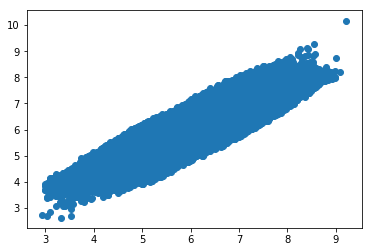

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.751
Model:                                  OLS   Adj. R-squared:                  0.751
Method:                       Least Squares   F-statistic:                 1.137e+04
Date:                      Wed, 28 Mar 2018   Prob (F-statistic):               0.00
Time:                              23:00:15   Log-Likelihood:            -2.5744e+05
No. Observations:                    679876   AIC:                         5.153e+05
Df Residuals:                        679695   BIC:                         5.173e+05
Df Model:                               180                                         
Covariance Type:                  nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                              -45.0885      1.815    -24.847      0.000     -48.645     -41.532
C(pickup_dropoff_same_Province)[T.1]    -0.0529      0.002    -23.686      0.000      -0.057      -0.049
C(pickup_Province)[T.Brooklyn]          -0.2321      0.021    -10.829      0.000      -0.274      -0.190
C(pickup_Province)[T.Manhattan]         -0.1641      0.021     -7.762      0.000      -0.206      -0.123
C(pickup_Province)[T.Queens]            -0.3463      0.021    -16.290      0.000      -0.388      -0.305
C(pickup_Province)[T.outward]           -0.1778      0.034     -5.189      0.000      -0.245      -0.111
C(dropoff_Province)[T.Brooklyn]         -0.0154      0.006     -2.378      0.017      -0.028      -0.003
C(dropoff_Province)[T.Manhattan]         0.0172      0.006      2.782      0.005       0.005       0.029
C(dropoff_Province)[T.Queens]            0.0436      0.006      6.892      0.000       0.031       0.056
C(dropoff_Province)[T.Staten Island]    -0.5692      0.040    -14.163      0.000      -0.648      -0.490
C(dropoff_Province)[T.outward]          -0.3523      0.010    -35.800      0.000      -0.372      -0.333
C(day_of_week)[T.1]                      0.0530      0.012      4.592      0.000       0.030       0.076
C(day_of_week)[T.2]                      0.0800      0.011      7.234      0.000       0.058       0.102
C(day_of_week)[T.3]                      0.0965      0.011      9.063      0.000       0.076       0.117
C(day_of_week)[T.4]                      0.1647      0.010     16.749      0.000       0.145       0.184
C(day_of_week)[T.5]                      0.2664      0.009     28.470      0.000       0.248       0.285
C(day_of_week)[T.6]                      0.2656      0.009     28.281      0.000       0.247       0.284
C(hr)[T.1]:C(day_of_week)[0]            -0.0192      0.014     -1.395      0.163      -0.046       0.008
C(hr)[T.2]:C(day_of_week)[0]         -5.603e-05      0.017     -0.003      0.997      -0.034       0.034
C(hr)[T.3]:C(day_of_week)[0]             0.0087      0.020      0.432      0.666      -0.031       0.048
C(hr)[T.4]:C(day_of_week)[0]            -0.0769      0.018     -4.170      0.000      -0.113      -0.041
C(hr)[T.5]:C(day_of_week)[0]            -0.0875      0.015     -5.937      0.000      -0.116      -0.059
C(hr)[T.6]:C(day_of_week)[0]             0.0132      0.011      1.208      0.227      -0.008       0.035
C(hr)[T.7]:C(day_of_week)[0]             0.2503      0.010     25.342      0.000       0.231       0.270
C(hr)[T.8]:C(day_of_week)[0]             0.4354      0.010     45.363      0.000       0.417       0.454
C(hr)[T.9]:C(day_of_week)[0]             0.4916      0.010     51.063      0.

In [148]:
reR6, y_newa6 = ReModeling(formulaIs6, fList6, filter_x_6)
reR6.summary()

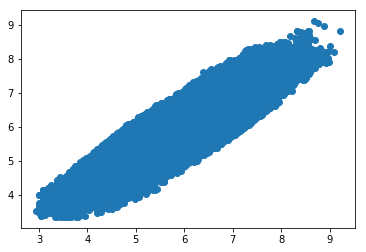

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.745
Model:                                  OLS   Adj. R-squared:                  0.745
Method:                       Least Squares   F-statistic:                 1.115e+04
Date:                      Wed, 28 Mar 2018   Prob (F-statistic):               0.00
Time:                              23:01:33   Log-Likelihood:            -2.6489e+05
No. Observations:                    679658   AIC:                         5.301e+05
Df Residuals:                        679479   BIC:                         5.322e+05
Df Model:                               178                                         
Covariance Type:                  nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                5.3885      0.023    233.973      0.000       5.343       5.434
C(pickup_dropoff_same_Province)[T.1]    -0.0663      0.002    -29.391      0.000      -0.071      -0.062
C(pickup_Province)[T.Brooklyn]          -0.1870      0.022     -8.523      0.000      -0.230      -0.144
C(pickup_Province)[T.Manhattan]         -0.1257      0.022     -5.802      0.000      -0.168      -0.083
C(pickup_Province)[T.Queens]            -0.3109      0.022    -14.277      0.000      -0.354      -0.268
C(pickup_Province)[T.outward]           -0.1465      0.035     -4.243      0.000      -0.214      -0.079
C(dropoff_Province)[T.Brooklyn]          0.2935      0.006     48.683      0.000       0.282       0.305
C(dropoff_Province)[T.Manhattan]         0.2605      0.006     43.514      0.000       0.249       0.272
C(dropoff_Province)[T.Queens]            0.1579      0.006     26.172      0.000       0.146       0.170
C(dropoff_Province)[T.Staten Island]     0.0741      0.039      1.891      0.059      -0.003       0.151
C(dropoff_Province)[T.outward]          -0.0146      0.009     -1.560      0.119      -0.033       0.004
C(day_of_week)[T.1]                      0.0497      0.012      4.250      0.000       0.027       0.073
C(day_of_week)[T.2]                      0.0775      0.011      6.931      0.000       0.056       0.099
C(day_of_week)[T.3]                      0.0946      0.011      8.785      0.000       0.073       0.116
C(day_of_week)[T.4]                      0.1643      0.010     16.521      0.000       0.145       0.184
C(day_of_week)[T.5]                      0.2706      0.009     28.584      0.000       0.252       0.289
C(day_of_week)[T.6]                      0.2713      0.010     28.543      0.000       0.253       0.290
C(hr)[T.1]:C(day_of_week)[0]            -0.0225      0.014     -1.623      0.105      -0.050       0.005
C(hr)[T.2]:C(day_of_week)[0]            -0.0037      0.018     -0.208      0.835      -0.038       0.031
C(hr)[T.3]:C(day_of_week)[0]             0.0074      0.021      0.359      0.720      -0.033       0.048
C(hr)[T.4]:C(day_of_week)[0]            -0.0877      0.019     -4.664      0.000      -0.125      -0.051
C(hr)[T.5]:C(day_of_week)[0]            -0.0918      0.015     -6.166      0.000      -0.121      -0.063
C(hr)[T.6]:C(day_of_week)[0]             0.0084      0.011      0.757      0.449      -0.013       0.030
C(hr)[T.7]:C(day_of_week)[0]             0.2472      0.010     24.732      0.000       0.228       0.267
C(hr)[T.8]:C(day_of_week)[0]             0.4378      0.010     45.096      0.000       0.419       0.457
C(hr)[T.9]:C(day_of_week)[0]             0.4953      0.010     50.857      0.

In [149]:
reR7, y_newa7 = ReModeling(formulaIs7, fList7, filter_x_7)
reR7.summary()

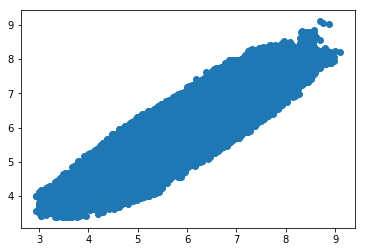

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     I(np.log(trip_duration))   R-squared:                       0.741
Model:                                  OLS   Adj. R-squared:                  0.741
Method:                       Least Squares   F-statistic:                     9888.
Date:                      Wed, 28 Mar 2018   Prob (F-statistic):               0.00
Time:                              23:02:55   Log-Likelihood:            -2.7621e+05
No. Observations:                    682409   AIC:                         5.528e+05
Df Residuals:                        682211   BIC:                         5.551e+05
Df Model:                               197                                         
Covariance Type:                  nonrobust                                         
==========================================================================================================================================
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                              -9.097e+07   2.39e+08     -0.381      0.703   -5.59e+08    3.77e+08
C(pickup_dropoff_same_Province)[T.1]                                    9.097e+07   2.39e+08      0.381      0.703   -3.77e+08    5.59e+08
C(pickup_Province)[T.Brooklyn]                                          9.097e+07   2.39e+08      0.381      0.703   -3.77e+08    5.59e+08
C(pickup_Province)[T.Manhattan]                                         9.097e+07   2.39e+08      0.381      0.703   -3.77e+08    5.59e+08
C(pickup_Province)[T.Queens]                                            9.097e+07   2.39e+08      0.381      0.703   -3.77e+08    5.59e+08
C(pickup_Province)[T.Staten Island]                                     3.032e+07   7.96e+07      0.381      0.703   -1.26e+08    1.86e+08
C(pickup_Province)[T.outward]                                           9.097e+07   2.39e+08      0.381      0.703   -3.77e+08    5.59e+08
C(dropoff_Province)[T.Brooklyn]:C(pickup_Province)[Bronx]               9.097e+07   2.39e+08      0.381      0.703   -3.77e+08    5.59e+08
C(dropoff_Province)[T.Manhattan]:C(pickup_Province)[Bronx]              9.097e+07   2.39e+08      0.381      0.703   -3.77e+08    5.59e+08
C(dropoff_Province)[T.Queens]:C(pickup_Province)[Bronx]                 9.097e+07   2.39e+08      0.381      0.703   -3.77e+08    5.59e+08
C(dropoff_Province)[T.Staten Island]:C(pickup_Province)[Bronx]         -3851.5021   1.01e+04     -0.381      0.703   -2.37e+04     1.6e+04
C(dropoff_Province)[T.outward]:C(pickup_Province)[Bronx]                9.097e+07   2.39e+08      0.381      0.703   -3.77e+08    5.59e+08
C(dropoff_Province)[T.Brooklyn]:C(pickup_Province)[Brooklyn]           -9.097e+07   2.39e+08     -0.381      0.703   -5.59e+08    3.77e+08
C(dropoff_Province)[T.Manhattan]:C(pickup_Province)[Brooklyn]              0.2916      0.162      1.796      0.073      -0.027       0.610
C(dropoff_Province)[T.Queens]:C(pickup_Province)[Brooklyn]                 0.1148      0.163      0.705      0.481      -0.204       0.434
C(dropoff_Province)[T.Staten Island]:C(pickup_Province)[Brooklyn]      -5762.5861   1.51e+04     -0.381      0.703   -3.54e+04    2.39e+04
C(dropoff_Province)[T.outward]:C(pickup_Province)[Brooklyn]                0.0796      0.229      0.347      0.729      -0.370       0.529
C(dropoff_Province)[T.Brooklyn]:C(pickup_Province)[Manhattan]              0.3420      0.007     50.470      0.000       0.329       0.355
C(dropoff_Province)[T.Manhattan]:C(pickup_Province)[Manhattan]         -9.097e+07   2.39e+08     -

In [150]:
reR8, y_newa8 = ReModeling(formulaIs8, fList8, filter_x_8)
reR8.summary()

#### 종속변수에 대한 독립변수의 영향도를 F 검정을 사용하여 비교

In [151]:
sm.stats.anova_lm(reR1,typ =2)

,sum_sq,df,F,PR(>F)
C(pickup_dropoff_same_Province),16.094666,1.0,1.195850e+02,7.839880e-28
C(pickup_Province),1954.025360,5.0,2.903722e+03,0.000000e+00
C(dropoff_Province),682.061749,5.0,1.013558e+03,0.000000e+00
C(hr):C(day_of_week),19679.126579,167.0,8.755565e+02,0.000000e+00
I(np.log(distance + 1)),147502.741936,1.0,1.095961e+06,0.000000e+00
hour_day_of_week_float,606.811077,1.0,4.508669e+03,0.000000e+00
dropoff_longitude,1262.063066,1.0,9.377259e+03,0.000000e+00
dropoff_latitude,416.553956,1.0,3.095039e+03,0.000000e+00
Residual,91396.175536,679083.0,NaN,NaN


In [152]:
sm.stats.anova_lm(reR2,typ =2)

,sum_sq,df,F,PR(>F)
C(pickup_dropoff_same_Province),16.101927,1.0,1.197936e+02,7.057547e-28
C(pickup_Province),1953.797024,5.0,2.907135e+03,0.000000e+00
C(dropoff_Province),678.325488,5.0,1.009308e+03,0.000000e+00
C(hr):C(day_of_week),19673.437072,167.0,8.764346e+02,0.000000e+00
I(np.log(distance + 1)),147419.882467,1.0,1.096761e+06,0.000000e+00
dropoff_longitude,1260.944677,1.0,9.381057e+03,0.000000e+00
dropoff_latitude,417.465884,1.0,3.105823e+03,0.000000e+00
Residual,91257.239557,678927.0,NaN,NaN


In [153]:
sm.stats.anova_lm(reR3,typ =2)

,sum_sq,df,F,PR(>F)
C(pickup_dropoff_same_Province),1.456362,1.0,1.056490e+01,0.001153
C(pickup_Province),1944.889689,5.0,2.821765e+03,0.000000
C(dropoff_Province),1224.398714,5.0,1.776432e+03,0.000000
C(hr):C(day_of_week),19535.924529,167.0,8.486202e+02,0.000000
I(np.log(distance + 1)),146472.015089,1.0,1.062553e+06,0.000000
Residual,93563.607242,678739.0,NaN,NaN


In [154]:
sm.stats.anova_lm(reR4,typ =2)

,sum_sq,df,F,PR(>F)
C(pickup_dropoff_same_Province),0.109219,1.0,7.700788e-01,0.380193
C(dropoff_Province):C(pickup_Province),1348.288333,35.0,2.716143e+02,0.000000
C(hr):C(day_of_week),19851.871189,167.0,8.381522e+02,0.000000
I(np.log(distance + 1)),147885.501420,1.0,1.042710e+06,0.000000
Residual,96661.908816,681543.0,NaN,NaN


In [155]:
sm.stats.anova_lm(reR5,typ =2)

,sum_sq,df,F,PR(>F)
C(pickup_dropoff_same_Province),70.078252,1.0,5.604635e+02,7.483691e-124
C(pickup_Province),906.229383,4.0,1.811933e+03,0.000000e+00
C(dropoff_Province),319.325127,5.0,5.107721e+02,0.000000e+00
C(hr):C(day_of_week),19637.775806,167.0,9.404590e+02,0.000000e+00
I(np.log(distance + 0.1)),161292.160667,1.0,1.289963e+06,0.000000e+00
hour_day_of_week_float,586.777949,1.0,4.692863e+03,0.000000e+00
dropoff_longitude,685.663857,1.0,5.483721e+03,0.000000e+00
dropoff_latitude,725.979803,1.0,5.806155e+03,0.000000e+00
Residual,85002.269513,679821.0,NaN,NaN


In [156]:
sm.stats.anova_lm(reR6,typ =2)

,sum_sq,df,F,PR(>F)
C(pickup_dropoff_same_Province),70.067795,1.0,5.610142e+02,5.681109e-124
C(pickup_Province),906.849548,4.0,1.815226e+03,0.000000e+00
C(dropoff_Province),318.823717,5.0,5.105473e+02,0.000000e+00
C(hr):C(day_of_week),19624.896230,167.0,9.409061e+02,0.000000e+00
I(np.log(distance + 0.1)),161199.031631,1.0,1.290678e+06,0.000000e+00
dropoff_longitude,684.059302,1.0,5.477081e+03,0.000000e+00
dropoff_latitude,725.391362,1.0,5.808015e+03,0.000000e+00
Residual,84890.424060,679695.0,NaN,NaN


In [157]:
sm.stats.anova_lm(reR7,typ =2)

,sum_sq,df,F,PR(>F)
C(pickup_dropoff_same_Province),110.306413,1.0,8.638464e+02,9.349088e-190
C(pickup_Province),927.140565,4.0,1.815187e+03,0.000000e+00
C(dropoff_Province),695.448289,5.0,1.089258e+03,0.000000e+00
C(hr):C(day_of_week),19624.128783,167.0,9.202582e+02,0.000000e+00
I(np.log(distance + 0.1)),160604.526317,1.0,1.257748e+06,0.000000e+00
Residual,86764.139811,679479.0,NaN,NaN


In [158]:
sm.stats.anova_lm(reR8,typ =2)

,sum_sq,df,F,PR(>F)
C(pickup_dropoff_same_Province),0.019089,1.0,1.450682e-01,0.703294
C(dropoff_Province):C(pickup_Province),736.820036,35.0,1.599846e+02,0.000000
C(hr):C(day_of_week),19880.588538,167.0,9.046853e+02,0.000000
I(np.log(distance + 0.1)),162597.273684,1.0,1.235657e+06,0.000000
Residual,89770.561097,682211.0,NaN,NaN


#### 잔차의 정규성을 확인

In [159]:
def Omini_jarque(result):
    test = sms.omni_normtest(result.resid)
    for xi in zip(['Chi^2', 'P-value'], test):
        print ("%-10s: %6.3f " % xi)
    test = sms.jarque_bera(result.resid)
    for xi in zip(['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis'], test):
        print("%-12s: %6.3f" % xi)

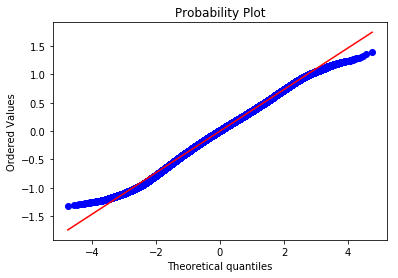

In [160]:
sp.stats.probplot(reR1.resid, plot=plt)
plt.show()

In [161]:
Omini_jarque(reR1)

Chi^2     : 1638.062 
P-value   :  0.000 
Jarque-Bera : 1662.840
P-value     :  0.000
Skew        : -0.114
Kurtosis    :  3.084


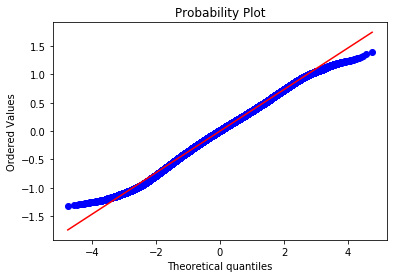

In [162]:
sp.stats.probplot(reR2.resid, plot=plt)
plt.show()

In [163]:
Omini_jarque(reR2)

Chi^2     : 1602.257 
P-value   :  0.000 
Jarque-Bera : 1624.779
P-value     :  0.000
Skew        : -0.113
Kurtosis    :  3.080


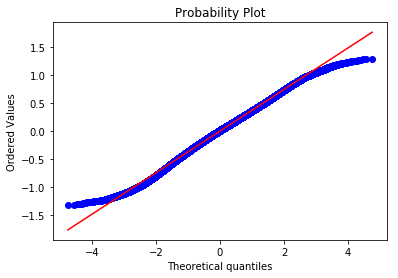

In [164]:
sp.stats.probplot(reR3.resid, plot=plt)
plt.show()

In [165]:
Omini_jarque(reR3)

Chi^2     : 2158.439 
P-value   :  0.000 
Jarque-Bera : 2184.087
P-value     :  0.000
Skew        : -0.135
Kurtosis    :  3.064


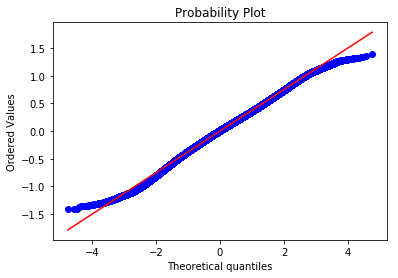

In [166]:
sp.stats.probplot(reR4.resid, plot=plt)
plt.show()

In [167]:
Omini_jarque(reR4)

Chi^2     : 2976.156 
P-value   :  0.000 
Jarque-Bera : 3130.290
P-value     :  0.000
Skew        : -0.141
Kurtosis    :  3.175


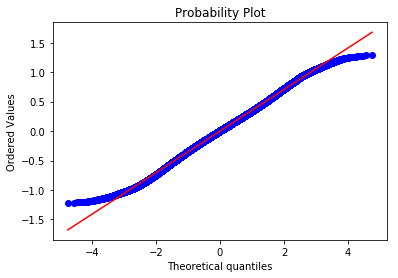

In [168]:
sp.stats.probplot(reR5.resid, plot=plt)
plt.show()

In [169]:
Omini_jarque(reR5)

Chi^2     : 509.408 
P-value   :  0.000 
Jarque-Bera : 553.717
P-value     :  0.000
Skew        : -0.036
Kurtosis    :  3.120


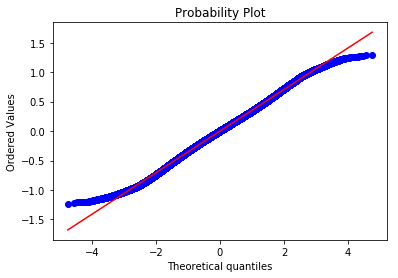

In [170]:
sp.stats.probplot(reR6.resid, plot=plt)
plt.show()

In [171]:
Omini_jarque(reR6)

Chi^2     : 484.815 
P-value   :  0.000 
Jarque-Bera : 525.638
P-value     :  0.000
Skew        : -0.035
Kurtosis    :  3.117


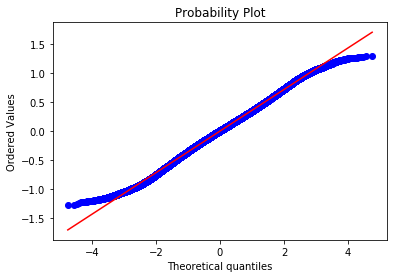

In [172]:
sp.stats.probplot(reR7.resid, plot=plt)
plt.show()

In [173]:
Omini_jarque(reR7)

Chi^2     : 570.524 
P-value   :  0.000 
Jarque-Bera : 598.595
P-value     :  0.000
Skew        : -0.052
Kurtosis    :  3.102


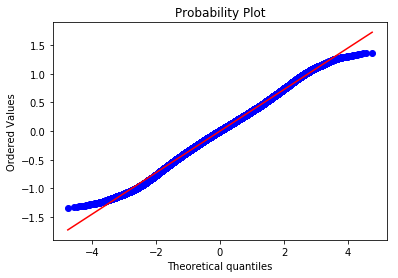

In [174]:
sp.stats.probplot(reR8.resid, plot=plt)
plt.show()

In [175]:
Omini_jarque(reR8)

Chi^2     : 1450.668 
P-value   :  0.000 
Jarque-Bera : 1696.805
P-value     :  0.000
Skew        : -0.056
Kurtosis    :  3.217


#### 잔차와 독립변수의 관계 확인
* 이분산성

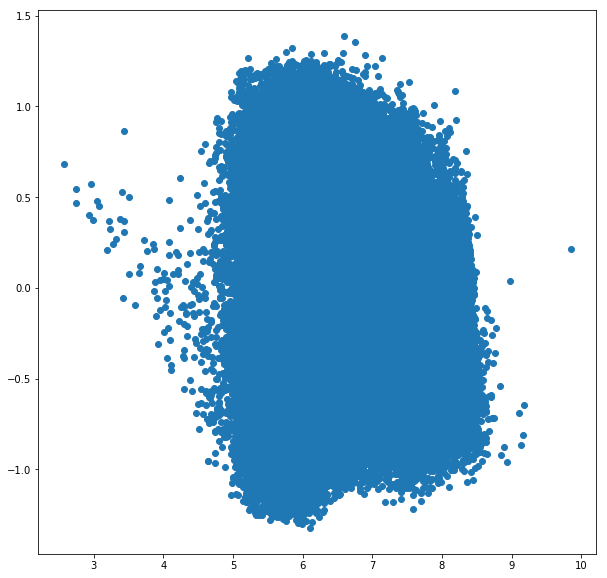

In [176]:
fig = plt.figure(figsize=(10,10))
plt.scatter(reR1.predict(),reR1.resid)
plt.show()

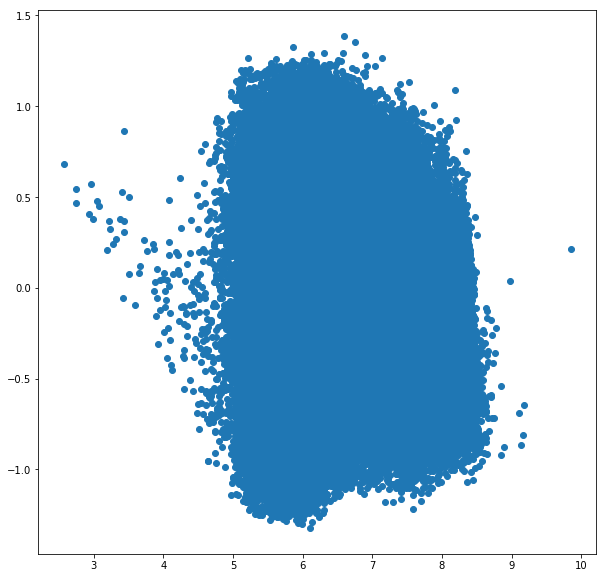

In [177]:
fig = plt.figure(figsize=(10,10))
plt.scatter(reR2.predict(),reR2.resid)
plt.show()

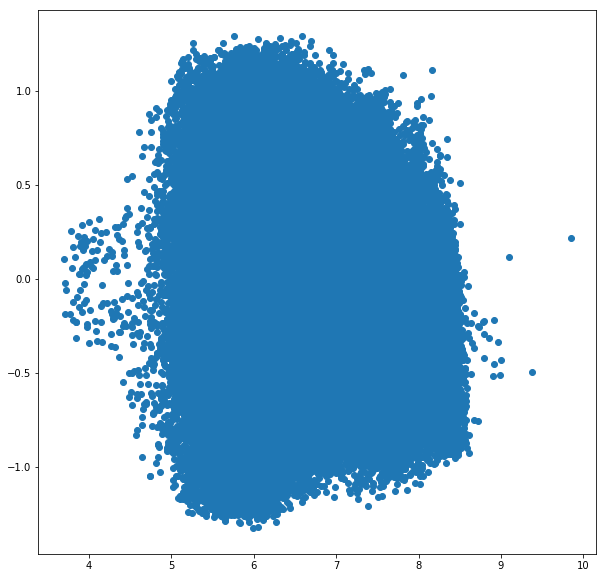

In [178]:
fig = plt.figure(figsize=(10,10))
plt.scatter(reR3.predict(),reR3.resid)
plt.show()

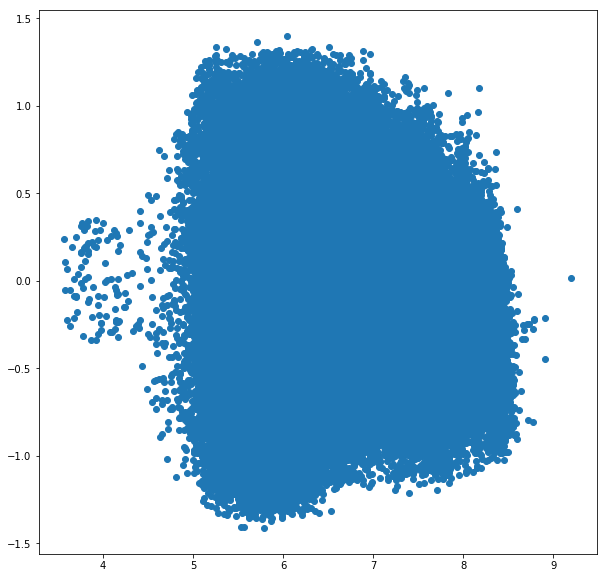

In [179]:
fig = plt.figure(figsize=(10,10))
plt.scatter(reR4.predict(),reR4.resid)
plt.show()

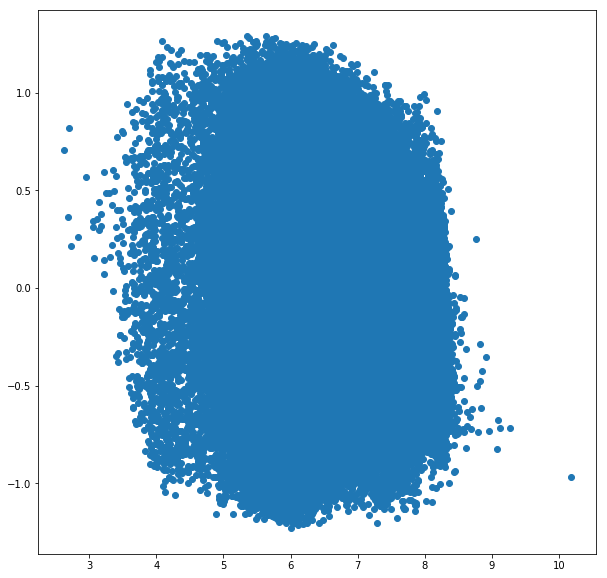

In [180]:
fig = plt.figure(figsize=(10,10))
plt.scatter(reR5.predict(),reR5.resid)
plt.show()

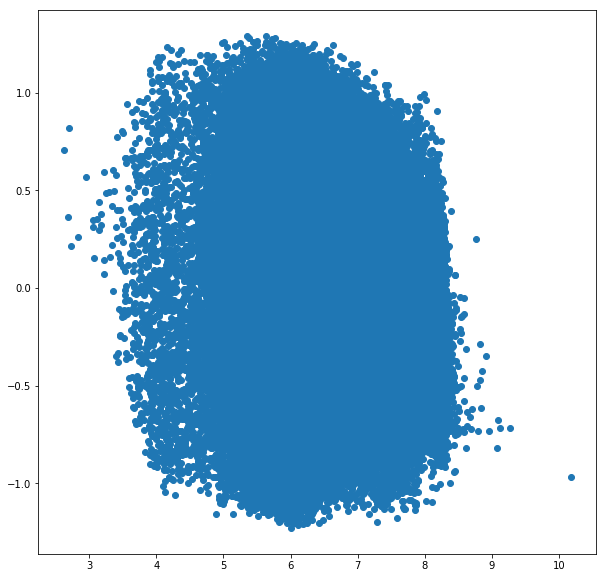

In [181]:
fig = plt.figure(figsize=(10,10))
plt.scatter(reR6.predict(),reR6.resid)
plt.show()

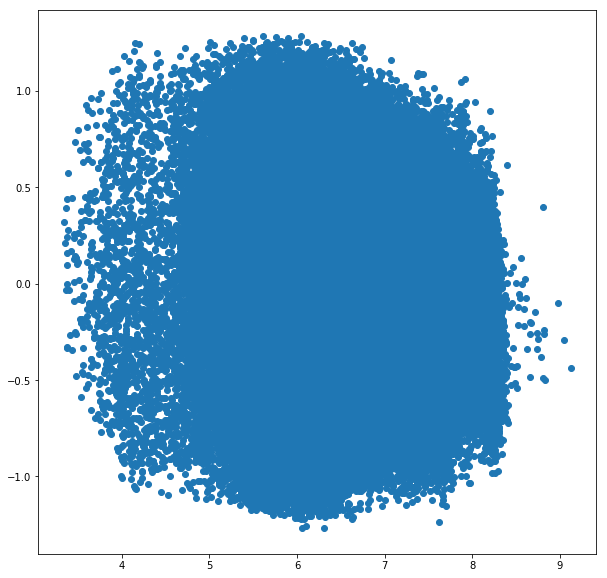

In [182]:
fig = plt.figure(figsize=(10,10))
plt.scatter(reR7.predict(),reR7.resid)
plt.show()

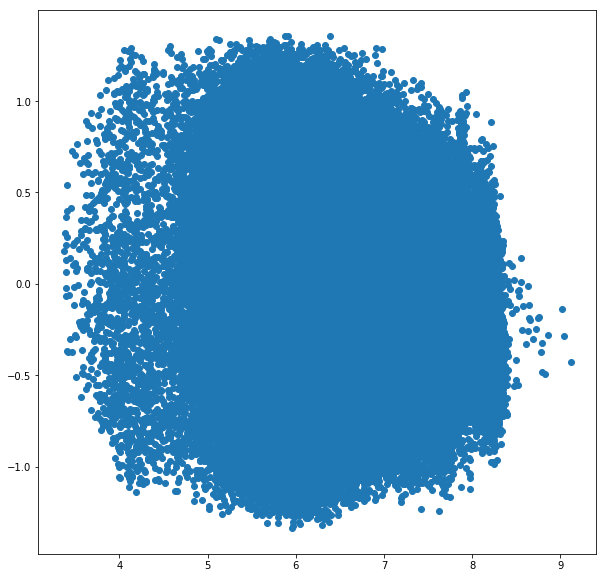

In [183]:
fig = plt.figure(figsize=(10,10))
plt.scatter(reR8.predict(),reR8.resid)
plt.show()

* 자기 상관 계수 확인

In [184]:
print (stools.durbin_watson(reR1.resid))

1.94136222554


In [185]:
print (stools.durbin_watson(reR2.resid))

1.94105691011


In [186]:
print (stools.durbin_watson(reR3.resid))

1.94360345141


In [187]:
print (stools.durbin_watson(reR4.resid))

1.94201558211


In [188]:
print (stools.durbin_watson(reR5.resid))

1.93668604638


In [189]:
print (stools.durbin_watson(reR6.resid))

1.93649306877


In [190]:
print (stools.durbin_watson(reR7.resid))

1.93787128748


In [191]:
print (stools.durbin_watson(reR8.resid))

1.93711503318


##### Root Mean Squared Logarithmic Error (RMSLE)

In [193]:
rmsle(filter_x_1['trip_duration'],np.exp(y_newa1))

0.36597090523329401

In [194]:
rmsle(filter_x_2['trip_duration'],np.exp(y_newa2))

0.36573540852606895

In [195]:
rmsle(filter_x_3['trip_duration'],np.exp(y_newa3))

0.37037838533139322

In [197]:
rmsle(filter_x_4['trip_duration'],np.exp(y_newa4))

0.37566164297445626

In [198]:
rmsle(filter_x_5['trip_duration'],np.exp(y_newa5))

0.35273028839315085

In [199]:
rmsle(filter_x_6['trip_duration'],np.exp(y_newa6))

0.35253167157644266

In [200]:
rmsle(filter_x_7['trip_duration'],np.exp(y_newa7))

0.3564567456426595

In [201]:
rmsle(filter_x_8['trip_duration'],np.exp(y_newa8))

0.36182368426228922

## Test 결과 도출

In [208]:
test = pd.read_csv('./data/transformed_test.csv')
test['hour_day_of_week_float'] = test['hr']/24 + test['day_of_week']
print ("Training data has {} rows and {} columns".format(test.shape[0],test.shape[1]))
print ("data : {}".format(test.shape[0]))
print ("Feature : {}".format(test.shape[1]))

Training data has 346797 rows and 25 columns
data : 346797
Feature : 25


In [209]:
print (test.shape)
test.head()

(346797, 25)


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,hr,...,dropoff_Province,pickup_dropoff_same_Province,pickup_Airport,dropoff_Airport,distance,dummy_manhattan_dist,bearing,rest_day,weekend,hour_day_of_week_float
0,id2332349,2,2016-06-30 23:59:00,5,-73.998291,40.722618,-73.971779,40.762470,N,23,...,Manhattan,1,N,N,4.962432,6.665590,26.741110,False,False,3.958333
1,id2013516,1,2016-06-30 23:59:00,2,-73.955109,40.689564,-73.978203,40.685802,N,23,...,Brooklyn,1,N,N,1.991625,2.365397,-102.114682,False,False,3.958333
2,id3719493,2,2016-06-30 23:59:00,1,-73.978416,40.791576,-73.973160,40.675968,N,23,...,Brooklyn,0,N,N,12.862675,13.297577,178.024967,False,False,3.958333
3,id0376262,1,2016-06-30 23:59:00,2,-73.873093,40.774097,-73.926704,40.856739,N,23,...,Manhattan,0,L,N,10.237132,13.703804,-26.132059,False,False,3.958333
4,id2105228,1,2016-06-30 23:58:00,1,-73.979416,40.755211,-74.003548,40.738224,N,23,...,Manhattan,1,N,N,2.774966,3.921490,-132.888582,False,False,3.958333


In [204]:
answer = pd.read_csv('./data/test_answer_nyc_taxi.csv',low_memory=False)
answer.dropna(axis=0,inplace = True)

In [211]:
testy1 = reR1.predict(test[fList1])
tx1 = pd.concat([test['id'],testy1],axis=1)
tx1.rename({0:"trip_duration"},inplace = True)
rmsle(answer.trip_duration, np.exp(testy1))

0.49831831565372242

In [212]:
testy2 = reR2.predict(test[fList2])
tx2 = pd.concat([test['id'],testy2],axis=1)
tx2.rename({0:"trip_duration"},inplace = True)
rmsle(answer.trip_duration, np.exp(testy2))

0.49831239027119811

In [213]:
testy3 = reR3.predict(test[fList3])
tx3 = pd.concat([test['id'],testy3],axis=1)
tx3.rename({0:"trip_duration"},inplace = True)
rmsle(answer.trip_duration, np.exp(testy3))

0.50118070749776311

In [214]:
testy4 = reR4.predict(test[fList4])
tx4 = pd.concat([test['id'],testy4],axis=1)
tx4.rename({0:"trip_duration"},inplace = True)
rmsle(answer.trip_duration, np.exp(testy4))

inf

In [215]:
testy5 = reR5.predict(test[fList5])
tx5 = pd.concat([test['id'],testy5],axis=1)
tx5.rename({0:"trip_duration"},inplace = True)
rmsle(answer.trip_duration, np.exp(testy5))

PatsyError: Error converting data to categorical: observation with value 'Staten Island' does not match any of the expected levels (expected: ['Bronx', 'Brooklyn', ..., 'Queens', 'outward'])
    I(np.log(trip_duration)) ~ I(np.log(distance + 0.1)) + hour_day_of_week_float + dropoff_longitude + dropoff_latitude + C(pickup_dropoff_same_Province) + C(hr):C(day_of_week) + C(pickup_Province) + C(dropoff_Province)
                                                                                                                                                                                    ^^^^^^^^^^^^^^^^^^

In [216]:
testy6 = reR6.predict(test[fList6])
tx6 = pd.concat([test['id'],testy6],axis=1)
tx6.rename({0:"trip_duration"},inplace = True)
rmsle(answer.trip_duration, np.exp(testy6))

PatsyError: Error converting data to categorical: observation with value 'Staten Island' does not match any of the expected levels (expected: ['Bronx', 'Brooklyn', ..., 'Queens', 'outward'])
    I(np.log(trip_duration)) ~ I(np.log(distance + 0.1)) + dropoff_longitude + dropoff_latitude + C(pickup_dropoff_same_Province) + C(hr):C(day_of_week) + C(pickup_Province) + C(dropoff_Province)
                                                                                                                                                           ^^^^^^^^^^^^^^^^^^

In [217]:
testy7 = reR7.predict(test[fList7])
tx7 = pd.concat([test['id'],testy7],axis=1)
tx7.rename({0:"trip_duration"},inplace = True)
rmsle(answer.trip_duration, np.exp(testy7))

PatsyError: Error converting data to categorical: observation with value 'Staten Island' does not match any of the expected levels (expected: ['Bronx', 'Brooklyn', ..., 'Queens', 'outward'])
    I(np.log(trip_duration)) ~ I(np.log(distance + 0.1))  + C(pickup_dropoff_same_Province) + C(hr):C(day_of_week) + C(pickup_Province) + C(dropoff_Province)
                                                                                                                     ^^^^^^^^^^^^^^^^^^

In [218]:
testy8 = reR8.predict(test[fList8])
tx8 = pd.concat([test['id'],testy8],axis=1)
tx8.rename({0:"trip_duration"},inplace = True)
rmsle(answer.trip_duration, np.exp(testy8))

0.49174055322021198

In [ ]:
tx.to_csv('./data/submission_Sigma.csv',index = False)

In [ ]:
rmsle(answer.trip_duration, np.exp(testy))